# Face Recognition Project

В этом проектк вы познакомитесь с задачей распознавания лиц, узнаете, как ее решать, и построите свой пайплан для решения этой задачи.

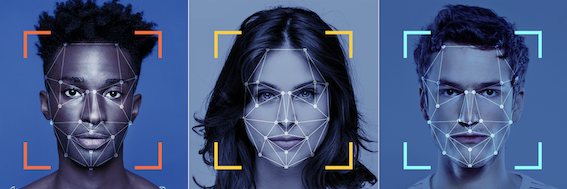

Для начала познакомимся с тем, как работает стандартный пайплан для распознавания лиц. Это не одна нейросеть, которая делает всю работу: это целых три отдельных стадии. После этого в разделе "задача проекта" расписано то, что нужно/можно делать в рамках этого проекта. **Пожалуйста, перед началом работы по проекту внимательно прочитайте раздел "задача проекта"!**

Ну а перед этим всем лучше разберемся с тем, какую задачу вообще мы хотим решать.

## Постановка задачи

Допустим, вы владеете компанией и хотите разработать систему распознавания лиц, чтобы применять ее в своем офисе. Например, чтобы ваши сотрудники могли сканировать лицо вместо прикладывания id карточек к турникетам при входе. Или для обеспечения безопасности в офисах (да, вы — хороший владелец компании, и используете face recognition только для обеспечения безопасности. Никакие данные не собираете, нигде долго не храните и никуда не передаете)  

Получается, вам нужна система, которая может принимать на вход видео, полученное с камер наблюдения, и на выходе выдавать, что за люди были замечены на этом видео. Ваша система должна уметь работать в случаях, когда лица людей запечатлены крупным или мелким планом, когда они чуть повернуты или наклонены, и когда на одном кадре с камеры находятся несколько лиц людей.

Вот решением такой задачи мы сейчас и займемся.

## Пайплайн для распознавания лиц, его обучение и тест

В этой части описано устройство пайплайна для распознавания лиц, а также принцип его обучения и тестирования.

### Пайплайн распознавания лиц

Обычно система распознавания лиц состоит из трех элементов:

- детекция лица (face detection);
- выравнивание лица (face alignment);
- распознавания лица (face recognition).

Давайте обсудим все этапы подробнее:

#### Детекция лиц

Пусть мы получили кадр с камеры наблюдения, на котором мы хотим распознать лица. Этот кадр может выглядеть как-то так:

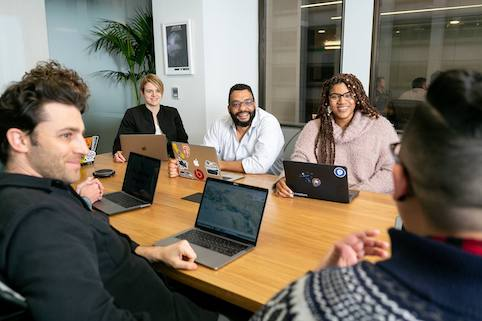

Первый этап обработки фото — детекция лиц на нем. Результат детекции может выглядеть примерно так:

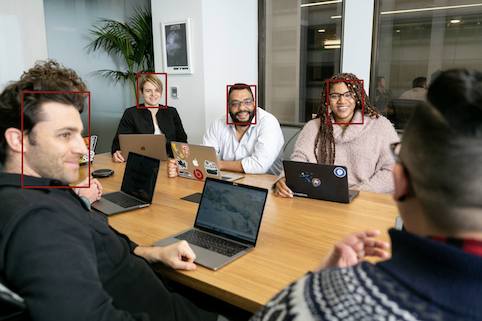

Для детекции лиц на фото может использоваться модель (например, нейросеть), обученная на задачу детекции лиц людей.

#### Выравнивание лиц


После этапа детекции работа с каждым детектированным лицом идет по отдельности
(точнее, с bounding box'ами каждого детектированного лица).

Второй этап — выравнивание лица. Он состоит из двух этапов:
1. На картинке ищутся ключевые точки лица (обычно это координаты зрачков глаз, кончик носа и точки вокруг рта). Для этой задачи используется отдельная модель (возможно, тоже нейросеть). У PyTorch есть [туториал](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) с кодом и описанием того, как подобная модель работает;
2. Повернуть и растянуть изображение так, чтобы точки глаз лица лежали на заданной горизонтальной линии, и чтобы между зрачками глаз было определенное расстояние.

Вот так это может выглядеть:

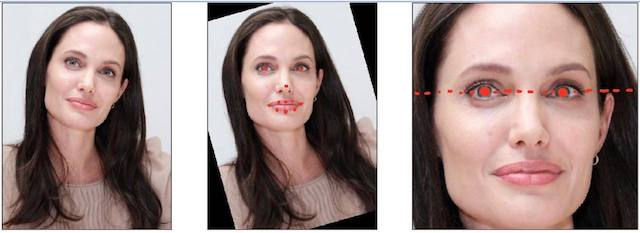

Таким образом, после второго этапа лица выглядят как-то так:

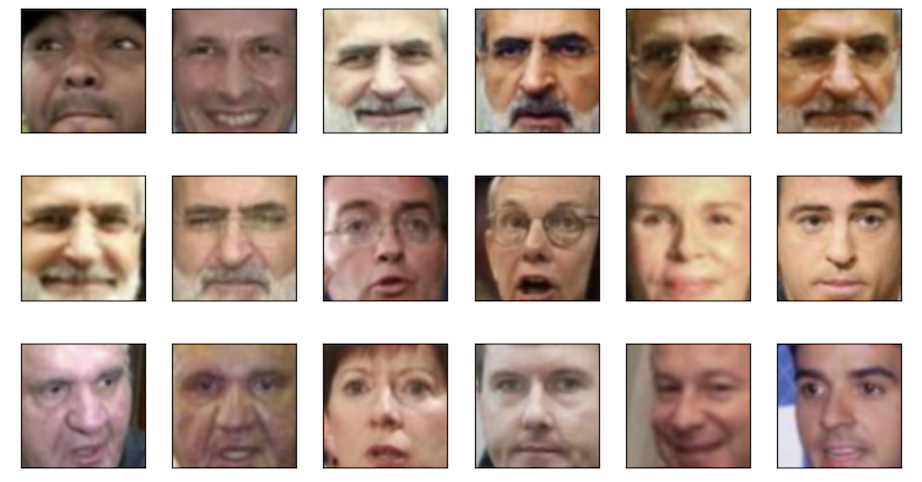

На таких картинках лиц и будет работать третья часть пайплайна — нейросеть, которая распознает лица.

**Зачем нужна стадия выравнивания**: выравнивание лиц датасета делает задачу распознавания лиц проще для модели на третьей стадии пайплайна. Если у всех лиц, которые принимает на вход модель, примерно одинаковый размер и все ключевые части (глаза, нос, рот) находятся в примерно одинаковых местах, это упрощает модели задачу понимания того, что за человек изображен на картинке. Модели не нужно "искать" глаза, рот и т.п. на картинке.

Практика подтверждает, что это сильно улучшает эффективность модели: без стадии выравнивания практически невозможно обучить хорошую систему распознавания лиц. Точнее, возможно, но только если есть очень-очень-очень много обучающих данных. Больше, чем практически у всех даже больших компаний.

#### Распознавание лиц

Третья часть пайплайна — это, собственно, распознавание лиц.

Что такое "распознавание": мы хотим построить такую нейросеть, которая принимает на вход картинку лица, а выдает вектор определенного размера. И мы хотим, чтобы векторы лиц одного и того же человека были близки по некоторому расстоянию (например, косинусному), а векторы лиц разных людей были далеки по этому же расстоянию. Обычно в качестве расстояния используется [косинусное расстояние](https://en.wikipedia.org/wiki/Cosine_similarity) (cosine distance).

Почему мы хотим построить именно такую сеть? Почему не посмтроить обычную сеть для классификации и научить ее классифицировать лица из обучающей выборки, где каждый отдельный человек — это один класс? Ответ такой — мы хотим, чтобы наша модель умела работать с лицами людей, которых нет в обучающей выборке. Хотим, чтобы она на лица одного и того же незнакомого человека выдавала близкие векторы (т.е. "говорила" нам, что это один и тот же человек), а на лица разных людей — далекие векторы.

Пусть тогда у нас есть база данных людей вида (id, набор векторов его лиц). Когда к нам придет новая картинка лица, мы ее прогоним через модель и получим вектор этого лица. Далее сравним этот вектор по метрике расстояния с векторами из нашей базы. Тот id, чьи векторы будут наиболее близки к нашему, и будет ответом на вопрос "кто изображен на картинке"



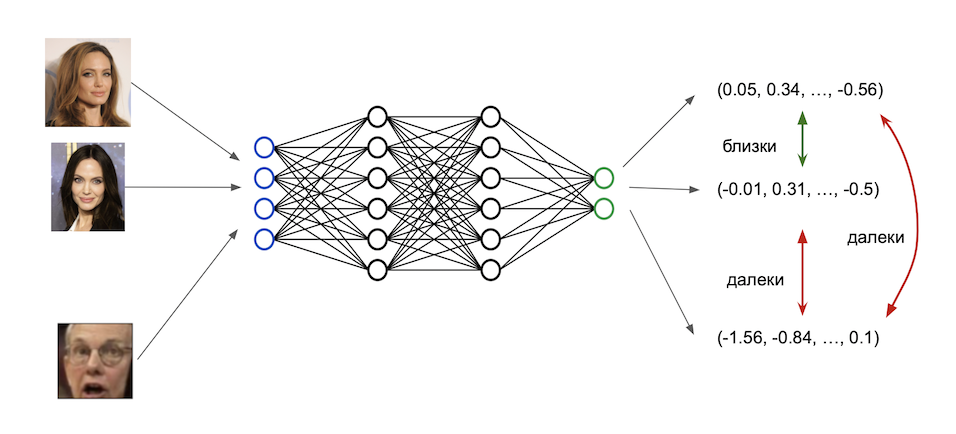

Такую сеть можно обучать разными способами. Два самых распространенных — такие:

1. Можно обучить нейросеть на обучающей выборке лиц на задачу классификации. Каждый отдельный человек — это один класс. В качестве лосс-функции можно использовать стандартную кросс-энтропию или специальные ее модификации (разберем ниже в ноутбуке). Затем, после обучения сети, выкинуть последний слой и считать вектором лица выход предпоследнего слоя сети. Это будет работать: полученные таким образом векторы лиц действительно будут близки для лиц одного и того же человека, и далеки для лиц разных людей. Причем это будет работать даже на тех лицах, которые не было в обучающей выборке (при условии, что обучающая выборка достаточно велика).

    У этого подхода есть недостаток: классов в обучающем датасете может быть очень много. Из-за этого последний слой сети станет очень широким. Это сделает обучение сети вычислительно затратным и сложным по памяти. Иногда приходится этот последний слой делить на несколько разных GPU, настолько он бывает большим.
2.  Можно пойти другим путем: обучать сеть напрямую на задачу "выдавать похожие эмбеддинги для лиц одного и того же человека, и далекие эмбеддинги для лиц разных людей". Это называется **contrastive training**.
    
    На каждой итерации обучения тогда происходит следующее:
    - берется картинка лица, к ней выбирается позитивная пара (еще одна картинка лица того же человека) и негативная (картинка лица другого человека). Все три картинки подаются на вход сети, на выходе получаются три вектора. Далее считается расстояние между векторами 1 и 2 и расстояние между векторами 1 и 3. Нейросеть обучается так, чтобы расстояние между векторами 1 и 2 было как можно меньше, а расстояние между векторами 1 и 3 — как можно больше.

    Лосс-функция в этом случае выглядит так:

 $$L = D(anchor, positive) - D(anchor, negative)$$

У contrastive loss тоже есть недостаток: его достаточно сложно настроить (подобрать к нему гиперпараметры).

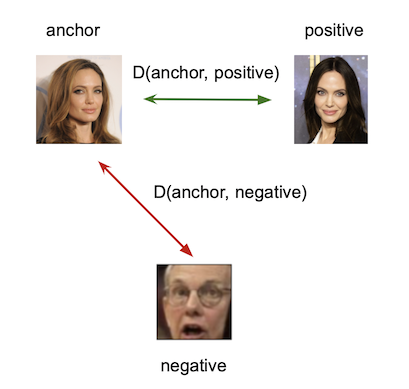

Вот так устроен пайплайн распознавания лиц, который мы хотим получить. Заметим, что все три части пайплайна обучаются отдельно.
- первая часть — это просто задача детекции;
- вторая часть — задача выравнивания фотографии лица;
- третья часть — задача распознавания лица по выровненной фотографии.

### Метрика качества для 3 части пайплайна

При обучении модели для распознавания лиц с помощью CE (кросс-энтропии) мы можем считать метрику accuracy как индикатор того, насколько хорошо наша модель работает. Но у accuracy тут есть недостаток: она не сможет померить, насколько хорошо наша модель работает на лицах людей, которых нет в обучающей выборке.  

Чтобы это исправить, придумали новую метрику: **identification rate**. Вот как она работает:

Создадим два набора изображений лиц: query и distractors. Никакие лица из этих наборов не должны содержаться в обучающем и валидационном датасете.

1. посчитаем косинусные расстояния между лицами, соответствующими одним и тем же людям из query части. Например, пусть одному человеку соответствуют три фото в query: 01.jpg, 02.jpg, 03.jpg. Тогда считаем три косинусных расстояния между всеми тремя парами из этих фото.
2. посчитаем косинусные расстояния между лицами, соответствующими разным людям из query части.
3. посчитаем косинусные расстояния между всеми парами лиц из query и distractors. Т.е. пара — это (лицо из query, лицо из distractors). Всего получится |query|*|distractors| пар.
4. Сложим количества пар, полученных на 2 и 3 шагах. Это количество false пар.
5. Зафиксируем **FPR** (false positive rate). Пусть, например, будет 0.01. FPR, умноженный на количество false пар из шага 4 — это разрешенное количество false positives, которые мы разрешаем нашей модели. Обозначим это количество через N.
6. Отсортируем все значения косинусных расстояний false пар. N — ое по счету значение расстояния зафиксируем как **пороговое расстояние**.
7. Посчитаем количество positive пар с шага 1, которые имеют косинусное расстояние меньше, чем пороговое расстояние. Поделим это количество на общее количество positive пар с шага 1. Это будет TPR (true positive rate) — итоговое значение нашей метрики.

Такая метрика обычно обозначается как TPR@FPR=0.01. FPR может быть разным. Приразных FPR будет получаться разное TPR.

Смысл этой метрики в том, что мы фиксируем вероятность ошибки вида false positive, т.е. когда "сеть сказала, что это один и тот же человек, но это не так", считаем порог косинусного расстояния для этого значения ошибки, потом берем все positive пары и смотрим, у скольких из них расстояние меньше этого порога. Т.е. насколько точно наша сеть ищет похожие лица при заданной вероятности ошибки вида false positive.

### Лосс-функции для 3 части пайплайна

Выше мы поняли, что нейросеть для распознавания лиц можно обучать разными способами. Два, которые мы упомянули — обучение сети на задачу классификации и с помощью contrastive loss. Давайте поговорим о том, какие лосс-функции мы можем использовать в том и в другом случае.



#### ArcFace Loss (Additive Angular Margin Loss)

В случае с обучением на задачу классификации лосс-функция, которая нам приходит в голову — Cross-Entropy. И на нее действительно можно обучать сеть для распознавания лиц. Но за много лет люди придумали более хитрые лосс-функции, которые делают обучение сети для распознавания лиц более эффективным. Одним из лучших считается ArcFace Loss (Additive Angular Margin Loss).

Этот лосс — чуть измененная кросс-энтропия. Он позволяет достичь лучшего распределения векторов лиц на сфере. В нем добавлены некоторые дополнительные ограничения и гиперпараметры, для того чтобы эмбеддинги лиц одного класса были более близки между собой, а эмбеддинги лиц разных людей оставались далеки. То есть, этот лосс позволяет лучше кластеризовать лица на сфере единичного радиуса.


**Как устроен ArcFace**:

Стандартные SoftMax + кросс-энтропия (CE) выглядят так:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

здесь:
- $x_i \in \mathbb{R^d}$ — вектор $i$-го элемента обучающей выборки перед последним полносвязным слоем сети. $y_i$ — класс этого элемента;
- $W_j \in \mathbb{R^d}$ — j-ый столбец матрицы весов последнего слоя сети (т.е. слоя, который производит итоговую классификацю входящего объекта);
- $b_j \in \mathbb{R^d}$ — j-ый элемент вектора байеса последнего слоя сети;
- $N$ — batch size;
- $n$ — количество классов.


Хотя этот лосс работает хорошо, он явным образом не заставляет эмбеддинги $x_i$ элементов, принадлежащих одному классу, быть близкими друг к другу по расстоянию. И не заставляет эмбеддинги элементов, принадлежащих разным классам, быть далеко друг от друга. Все, что хочет этот лосс — чтобы на основе эмбеддингов $x_i$ можно было хорошо классифицировать элементы, никакие ограничений на расстояния между эмбеддингами $x_i$ он не вводит.

Из-за этого у нейросетей для распознавания лиц, которые обучены на обычном CE loss, бывают проблемы с распознаванием лиц, которые сильно отличаются от лиц того же человека разными допатрибутами (шляпа/прическа/очки и т.п.). Просто эмбеддинг для таких лиц получается довольно далек по расстоянию от других эмбеддингов лиц этого же человека.

Давайте теперь немного поправим формулу:
- уберем байес последнего слоя, т.е. сделаем $b_j=0$;
- нормализуем веса последнего слоя: ||$W_j$|| = 1;
- нормализуем эмбеддинги: ||$x_i$|| = 1. Перед подачей их на вход последнему слою (т.е. перед умножением на матрицу $W_j$) умножим их на гиперпараметр s. По сути, мы приводим норму всех эмбеддингов к s. Смысл этого гиперпараметра в том, что, возможно, сети проще будет классифицировать эмбеддинги, у которых не единичная норма.

Нормализация эмбеддингов приводит к тому, что эмбеддинги начинают быть распределены по сфере единичного радиуса (и сфере радиуса s после умножения на ниперпараметр s). И итоговые предсказания сети после последнего слоя зависят только от угла между эмбеддингами $x_i$ и выученных весов $W_j$. От нормы эмбеддинга $x_i$ они больше не зависят, т.к. у всех эмбеддингов они теперь одинаковые.

Получается, в степени экспоненты у нас останется выражение $s W_{y_i}^{T}x_i$, которое можно переписать в виде  $s W_{y_i}^{T}x_i = s ||W_{y_i}||\cdot ||x_i|| \cdot cos\Theta_{y_i}$. Тут $\Theta_{y_i}$ — это угод между векторами $W_{y_i}$ и $x_i$. Но так как мы сделали нормы $W_{y_i}$ и $x_i$ единичными, то все это выражение просто будет равно $s cos\Theta_{y_i}$.

В итоге мы получим следующую формулу лосса:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$


И последний шаг. Добавим еще один гиперпараметр $m$. Он называется additive angular margin penalty и заставляет эмбеддинги одного класса быть ближе друг к другу, а эмбеддинги разных классов — более далекими друг от друга.

В итоге получим вот что:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Это и есть ArcFace Loss с двумя  гиперпараметрами, s и m.

Получается, что ArcFace Loss завтавляет сеть выучивать эмбеддинги, распределенные по сфере радиуса s, причем чтобы эмбеддинги одного класса были ближе друг к другу, а эмбеддинги разных классов — более далеки друг от друга.



**Доплитература по ArcFace Loss:**

Оригинальная статья: https://arxiv.org/pdf/1801.07698.pdf

Репозиторий с кодом: https://github.com/deepinsight/insightface

#### Triplet Loss

Triplet Loss — это один из лоссов для contrastive learning. Чтобы учить модель с помощью этого лосса, модели не нужен последний классификационный слой. Этот лосс работает прямо с эмбеддингами $x_i$ элементов, которые выдает модель.

Снова скажем, что идея лосса — заставить эмбеддинги лиц одного человека быть более близкими по некоторому расстоянию, а эмбеддинги лиц разных людей — далекими друг от друга. Общая формула лосса выглядит так:

$$L(e, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

здесь
- $e$ — эмбеддинг входного лица (output модели)
- $p$ — "positive" эмбеддинг для входного лица (т.е. эмбеддинг такого элемента, что мы хотим, чтобы $e$ и $p$ были близки. В нашем случае это значит, что $e$ и $p$ должны быть выходами сети на два разных фото одного и того же человека).
- $n$ — "negative" эмбеддинг для входного лица (т.е. эмбеддинг такого элемента, что мы хотим, чтобы $e$ и $p$ были далеки. В нашем случае это значит, что $e$ и $p$ должны быть выходами сети на два разных фото разных людей).
- $d(x, y)$ — метрика расстояния между эмбеддингами, по которой мы их сравниваем.
- margin — гиперпараметр, который заставляет $d(a, p)$ и $d(a, n)$ быть еще дальше друг от друга.

**Эмбеддинги $e$, $p$ и $n$ нужно нормализовать, прежде чем подавать в лосс-функцию**.

У TripletLoss есть куча разных вариаций. В некоторых из них больше гиперпараметров, в других предлагают использовать больше одного позитивного и негативного эмбеддинга за раз. Где-то предлагается умный способ выбора negative эмбеддинга (например, выбирается такой, на котором нейросеть пока плохо работает, т.е. считает $e$ и $n$ близкими).

Пример реализации TripletLoss можно найти [здесь](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss).

Будьте готовы, что TripletLoss придется настраивать, чтобы добиться хорошего результата при обучении сети.


**Что нужно учесть при реализации Triplet Loss**:
- при обучении мы обычно хотим следить за ходом обучения модели, считая какую-то метрику качества. Тут у нас больше нет классификационного слоя, так что accuracy мы считать не можем. Нужно придумать, как в случае Triplet Loss считать метрику качества на вализации в течение обучения. Подумайте, как можно это сделать?
- скорее всего, чтобы обучить сеть на Triplet Loss, придется написать кастомный Dalaset/Dataloader, который будет возвращать тройки элементов (anchor, positive, negative).
- не забудьте нормализовать эмбеддинги перед подсчетом лосса! Это можно сделать руками, а можно, например, добавить в конец сети batchnorm без обучаемых параметров.

**Доплитература по Triplet Loss**:

- Идея TripletLoss: https://en.wikipedia.org/wiki/Triplet_loss
- Хорошая статья про batch mining techniques для выбора positive и negative элементов: https://omoindrot.github.io/triplet-loss#triplet-mining
- Реализация TripletLoss в PyTorch : https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss
- Еще одна реализация TripletLoss: https://github.com/alfonmedela/triplet-loss-pytorch/blob/master/loss_functions/triplet_loss.py

#### Другие лосс-функции

Кроме ArcFace и Triplet Loss, есть еще много разных вариантов лоссов для задачи face recognition. Некоторые из них можно найти, например, [тут](https://openaccess.thecvf.com/content_CVPRW_2020/papers/w48/Hsu_A_Comprehensive_Study_on_Loss_Functions_for_Cross-Factor_Face_Recognition_CVPRW_2020_paper.pdf). Вы можете попробовать реализовать другие лосс-функции в этом проекте.

Кроме этого, можно миксовать лосс-функции. Например, обучать нейросеть на сумме ArcFace и TripletLoss. Часто так выходит лучше, чем если обучать на каком-то одном лоссе.

## Задача проекта

В целом, **задача проекта — реализовать один или несколько частей системы распознавания лиц**. Вот что можно делать:

- (2 балла, обязательная часть!) Обучить нейросеть для 3 части пайплайна (распознавание лиц) на CE loss. Для этого можно использовать нейросети, предобученные на ImageNet. Нельзя брать нейросети, которые уже предобучены на распознавание лиц! Добиться достаточного качества классификации.
- (2 балла) Обучить нейросеть для поиска ключевых точек лица и написать код, который принимает на вход фотографию лица и возвращает выровненное лицо на основе найденных точек (т.е. реализовать вторую часть пайплайна face recognition);
- (2 балла) Собрать весь пайплайн распознавания лиц. Этому пайплайну должно быть можно подать на вход картинку с лицами, и пайплайн должен возвращать эмбеддинги всех найденных лиц. Хорошо будет продемонстрировать работу вашего пайплайна на паре лиц одинаковых и разных людей с подсчетом метрики расстояния между их эмбеддингами. В пайплайне можно использовать предобученную сеть для детекции лиц, или же обучить свою;
- (2 балла) Реализовать Identification Rate Metric (ниже дан шаблон кода для него и ячейки для тестирования);
- (2 балла) Реализовать ArcFace loss, обучить сеть с нуля на нем. Добиться достаточного качества классификации;
- (2 балла) Реализовать Triplet loss, обучить сеть с нуля на нем. Добиться достаточного качества классификации;
- (1 балл) Обучить сеть на смеси ArcFace loss и Triplet loss. Добиться достаточного качества классификации;
- (2 балла) Исследовать литературу, статьи по Face Recognition, написать literature review с обзором современных методов, улучшений сети и пайплайна.
- (2 балла) Исследовать пространство полученных эмбеддингов. Например, как в случае Arcface Loss расположены эмбеддинги на сфере? Где расположены эмбеддинги картинок-аутлаеров? (например, если лицо на картинке сильно смазано или почти не видно. Или это вообще не картинка лица). Как еще можно исследовать модель?
- Улучшить сеть с помощью разных трюков. Например, попробовать другие лосс-функции, поискать статьи с разными улучшениями и попробовать что-то закодить. Баллы тут зависят от сложности улучшения и вашей иреализации.

Пожалуйста, пишите подробные комментарии к своему коду. Вставляйте ссылки на статьи, где нашли какие-то трюки. Объясняйте, почему реализовали что-то именно так. Будет классно, если вы опишете свой путь в экспериментах при работе с оубчением модели или Triplet Loss.


**Данные. Какие данные можно использовать для выполнения проекта:**

Для третьей части пайплайна (нейросети для распознавания лиц) есть такие варианты:
- Я подготовила данные лиц 500 людей CelebA-500. Они уже выровнены. Скачать можно тут: https://disk.yandex.ru/d/S8f03spLIA1wrw
    Внутри:
        - celebA_imgs — папка с выровненными картинками;
        - celebA_anno.txt — файл с аннотацией — каждой картинке из celebA_imgs поставлен в соответствие ее id;
        - celebA_train_split.txt — файл со сплитом на train/val/test.
    Эти данные — часть открытого датасета [CelebA](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fmmlab.ie.cuhk.edu.hk%2Fprojects%2FCelebA.html), который один из стандартных для обучения моделей, связанных с лицами.
- Использовать любые другие данные. Например, можно взять больше картинок из [CelebA](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fmmlab.ie.cuhk.edu.hk%2Fprojects%2FCelebA.html). Или вот еще один популярный датасет: [LFW](https://colab.research.google.com/corgiredirector?site=http%3A%2F%2Fvis-www.cs.umass.edu%2Flfw%2F). Обращайте внимание на то, выровнены ли лица в том датасете, который вы скачиваете, и кропайте картинки так, чтобы на них оставалось преимущественно лицо.


Может быть удобно сначала проверить вашу сеть на данных CelebA-500, а затем переходить к ее обучению на большем датасете.

Для обучения других частей пайплайна данные нужно выбрать самим. Разные части пайплайна можно обучать на разных данных. Но нужно, чтобы затем весь пайплайн хорошо работал на новых лицах.

- Для тестирования кода Identification Rate Metric я также подготовила данные из CelebA, которые выровнены точно так же, как картинки из CelebA-500. Если вы обучили нейросеть на датасете CelebA-500, можете ее тестировать с помощью этих данных. Ссылка на них есть в разделе "шаблон кода для Identification Rate Metric" ниже в ноутбуке.



**Проект оценивается из 10 баллов. Чтобы проект считался сданным, нужно набрать 5 или более баллов.**  Можно выполнять любые части проекта, которые описаны выше, баллы будут суммироваться. Единственная обязательная часть — обучение сети с нуля на CE loss.

Самый простой (на мой взгляд) набрать 6 баллов:
- (2 балла) Обучить нейросеть для распознавания лиц на датасете CelebA-500. Чтобы получить два балла, нужно добиться accuracy на тестовой части >0.7;
- (2 балла) Реализовать Identification Rate Metric, протестировать ее на предоставленных данных;
- (2 балла) Реализовать ArcFace loss, обучить сеть с нуля на нем. Добиться accuracy на тестовой части >0.7;



## Модель распознавания

In [1]:
import numpy as np
import random
import torch
from torch.utils.data import Dataset, ConcatDataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torchvision import models
from torchvision.transforms import v2
import imgaug
import imgaug.augmenters as iaa
from torchvision.utils import make_grid
import os
import pickle
import copy
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

print(torch.__version__)
print(torchvision.__version__)
print(imgaug.__version__)
print(sns.__version__)

2.1.2
0.16.1
0.4.0
0.12.2


In [2]:
import random
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

### Загрузка данных

Данные для обучения брал [отсюда](https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8?resourcekey=0-5BR16BdXnb8hVj6CNHKzLg). Выровненные картинки буду хранить в оперативной памяти, остальное - на жестоком диске. 

In [5]:
working_dir = '/tmp/working'
img_align = '/mnt/hd0/data/CelebA/Img/img_align_celeba.zip'
identity = '/mnt/hd0/data/CelebA/Anno/identity_CelebA.txt'
eval_partition = '/mnt/hd0/data/CelebA/Eval/list_eval_partition.txt'

In [6]:
os.makedirs(working_dir, exist_ok=True)
sample_dir = os.path.join(working_dir, 'img_align_celeba')
if not os.path.exists(sample_dir):
    !unzip -q $img_align -d $working_dir

In [7]:
files = open(identity, 'r')
files = [f.strip().split() for f in files.readlines()]
imgs = np.array([f[0] for f in files])
labels = np.array([int(f[1]) for f in files])

In [8]:
files = open(eval_partition, 'r')
idx = np.array([int(f.strip().split()[1]) for f in files.readlines()])
train_idx = np.where(idx == 0)[0]
val_idx = np.where(idx == 1)[0]
test_idx = np.where(idx == 2)[0]
print('%.2f %.2f %.2f' % (train_idx.size/idx.size, val_idx.size/idx.size, test_idx.size/idx.size))

0.80 0.10 0.10


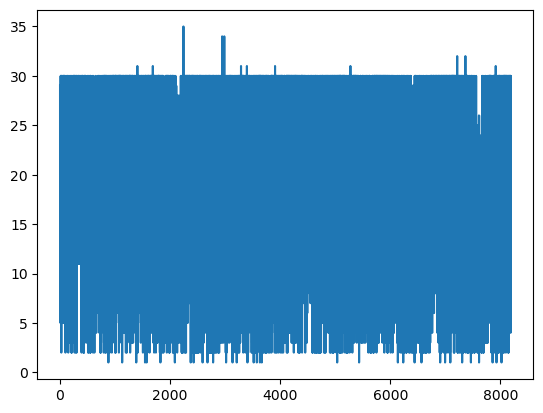

In [9]:
unique, counts = np.unique(labels[train_idx], return_counts=True)
plt.plot(counts);

Для обучения буду использовать фото 500 человек и только те классы, для которых имеется 30 изображений. 

In [10]:
tr_ids = unique[counts == 30][:500]
train_idx = train_idx[np.isin(labels[train_idx], tr_ids)]
train_idx.size

15000

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

train_imgs = imgs[train_idx]
le = LabelEncoder()
train_labels = le.fit_transform(labels[train_idx])

train_imgs, \
test_imgs, \
train_labels, \
test_labels = train_test_split(train_imgs, train_labels, test_size=1500, stratify=train_labels)

train_imgs, \
val_imgs, \
train_labels, \
val_labels = train_test_split(train_imgs, train_labels, test_size=1500, stratify=train_labels)

size = labels[train_idx].size

print('%.2f %.2f %.2f' \
% (train_labels.size/size, val_labels.size/size, test_labels.size/size))

0.80 0.10 0.10


Итого 12000, 1500 и 1500 изображений (24, 3 и 3 фото на человека) в обучающей, валидационной и тестовой выборках соответственно. </br>
Посмотрим на выровненные картинки.

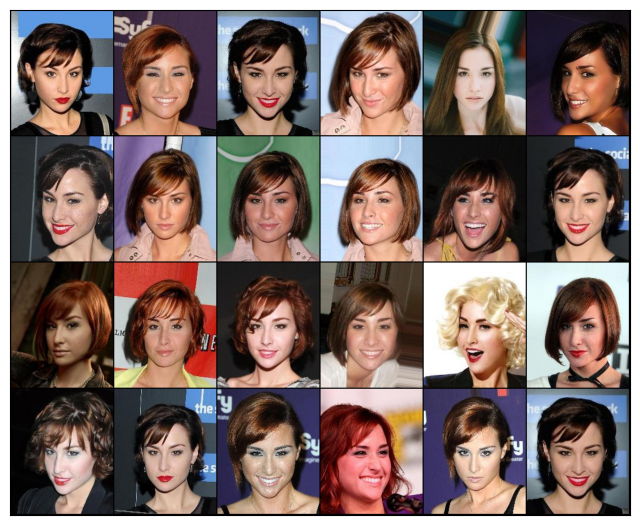

In [12]:
sample_id = 42
vfun = np.vectorize(lambda x: os.path.join(sample_dir, x))
samples = vfun(train_imgs)
samples = samples[np.where(train_labels == sample_id)]
samples = torch.tensor(np.array([np.array(Image.open(sample)) for sample in samples]))
grid_img = make_grid(samples.permute(0,3,1,2), nrow=6)
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(grid_img.permute(1,2,0));

### Предобработка изображений

Чтобы избежать переобучения, буду использовать [Cutout](https://imgaug.readthedocs.io/en/latest/source/overview/arithmetic.html#cutout). Идея в том, что сеть каждый раз получает картинки, в которых нет отдельных деталей, что мешает ей просто запомнить всю обучающую выборку. Полученные аугментации стакаю с исходными изображениями.

In [13]:
class CelebA_Dataset(Dataset):
    def __init__(self, files, labels, path, mode='train', transform=None, rescale_size=224):
        super().__init__()
        vfun = np.vectorize(lambda x: os.path.join(path, x))
        self.files = vfun(np.array(files))
        self.labels = np.array(labels)
        self.mode = mode
        self.transform = transform
        self.rescale_size = rescale_size
        self.len_ = len(files)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        x = self._load_and_transform(self.files[index])
        y = self.labels[index]
        if self.mode != 'test':
            transform = v2.RandomHorizontalFlip()
            x = transform(x)
            if self.transform:
                x = self._transform(x, self.transform)
        return x, y

    def _prepare_sample(self, image):
        image = image.resize((self.rescale_size, self.rescale_size))
        return np.array(image)
    
    def _load_and_transform(self, file):
        transform = v2.Compose([
            v2.ToImage(), 
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            v2.CenterCrop(112),
        ])
        x = self.load_sample(file)
        x = self._prepare_sample(x)
        x = np.array(x/255, dtype='float32')
        return transform(x)

    def _transform(self, image, transform):
        image = transform(image=image.permute(1,2,0).numpy())
        image = torch.tensor(image).permute(2,0,1)
        return image

In [14]:
n_classes = len(np.unique(train_labels))
batch_size = 128
num_workers = 4

seq = iaa.Sequential([
    iaa.Cutout(nb_iterations=(3, 11), size=0.14, fill_mode='gaussian'),
])

train_dataset = ConcatDataset([
    CelebA_Dataset(train_imgs, train_labels, sample_dir),
    CelebA_Dataset(train_imgs, train_labels, sample_dir, transform=seq)
])
val_dataset = CelebA_Dataset(val_imgs, val_labels, sample_dir, mode='test')
test_dataset = CelebA_Dataset(test_imgs, test_labels, sample_dir, mode='test')

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=True
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=False
)
len(train_loader), len(val_loader), len(test_loader)

(188, 12, 12)

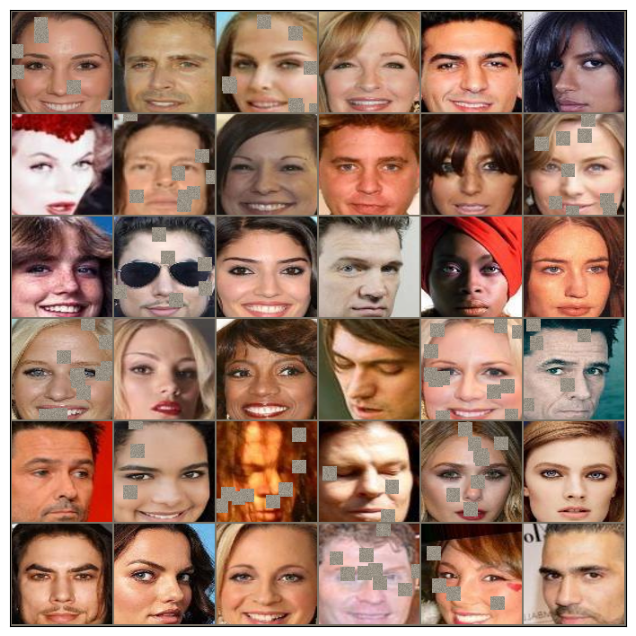

In [15]:
samples, _ = next(iter(train_loader))
grid_img = make_grid(samples[:36], nrow=6).permute(1,2,0) * std + mean
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xticks([])
ax.set_yticks([])
grid_img = grid_img/torch.amax(grid_img)
grid_img = np.clip(grid_img, 0, 1)
plt.imshow(grid_img);

### Архитектура

In [16]:
class ResNet50(torch.nn.Module):
    def __init__(self, n_classes=500, normalize_features=True):
        super(ResNet50, self).__init__()
        self.net = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        for param in self.net.parameters():
            param.requires_grad = False
        for param in self.net.layer4.parameters():
            param.requires_grad = True
        self.net.fc = torch.nn.Linear(self.net.fc.in_features, n_classes, bias=False)
        self.normalize_features = normalize_features
    
    def forward(self, x, return_features=False):
        if self.normalize_features:
            seq = torch.nn.Sequential(*list(self.net.children())[:-1])
            x = seq(x)
            x = F.normalize(x.reshape(-1, self.net.fc.in_features), dim=1)
            if return_features:
                return x
            x = self.net.fc(x)
            return F.normalize(x, dim=1)
        else:
            x = self.net(x)
            return x

In [17]:
np.sum([param.requires_grad for param in ResNet50().parameters()])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/yorkie/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:08<00:00, 11.5MB/s]


31

### Функции для обучения

In [18]:
def fit_epoch(model, train_loader, criterion, optimizer, embeddings=False):
    running_loss = 0.
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs, return_features=embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion, embeddings=False):
    model.eval()
    running_loss = 0.
    running_corrects = 0
    processed_data = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs, return_features=embeddings)
            loss = criterion(outputs, labels)
        
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    
    val_loss = running_loss / processed_data
    val_acc = running_corrects.cpu().numpy() / processed_data
    return val_loss, val_acc

In [19]:
class EarlyStopping:
    ''' Checkpoints and early stopping
    '''
    def __init__(self, path, patience=5, delta=0):
        self.patience = patience
        self.count = 0
        self.best = None
        self.state = False
        self.min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, model, loss):
        if np.isnan(loss):
            self.state = True
        else:
            score = -loss
            if self.best is None:
                self.best = score
                self.checkpoint(model, loss)
            elif score < self.best + self.delta:
                self.count += 1
                if self.count >= self.patience:
                    self.state = True
            else:
                self.best = score
                self.checkpoint(model, loss)
                self.count = 0

    def checkpoint(self, model, loss):
        torch.save(model.state_dict(), self.path)
        self.min = loss

In [20]:
def train(model, criterion, epochs=50, lr=1e-3, weight_decay=5e-4, step_size=5, step_gamma=0.5, 
          embeddings=False, verbose=1): 
    
    state_dict = os.path.join(working_dir, 'checkpoint.pt')
    early_stopping = EarlyStopping(path=state_dict)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=step_gamma)
    
    history = []
    print('Epoch\tLr\t Loss_t\t Loss_v\t Acc_t\t Acc_v')
          
    for epoch in range(epochs):
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, embeddings)
        val_loss, val_acc = eval_epoch(model, val_loader, criterion, embeddings)
        scheduler.step()
        history.append((train_loss, train_acc, val_loss, val_acc))
        if not epoch % verbose:
            lr = scheduler.optimizer.param_groups[0]['lr']
            print('%d/%d\t%.1e\t %.3f\t %.3f\t %.4f\t %.4f' \
                  % (epoch+1, epochs, lr, train_loss, val_loss, train_acc, val_acc))

        early_stopping(model, val_loss)
        if early_stopping.state:
            break
    model.load_state_dict(torch.load(state_dict))
    
    return history

### Подбор гиперпараметров

Здесь сохраняю accuracy, чтобы потом сравнить с AcrFace Loss.

In [20]:
from hyperopt import hp, fmin, tpe, STATUS_OK
from hyperopt.early_stop import no_progress_loss

acc = []

def hyperopt_objective(params):
    print(params)
    criterion = torch.nn.CrossEntropyLoss()
    model = ResNet50(normalize_features=False).to(device)
    history = train(model, criterion, **params, verbose=5)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion)
    acc.append(val_acc.item())
    print('Total Acc: %.4f' % val_acc.item())
    return {'loss': val_loss, 
            'status': STATUS_OK}

space = {
    'lr': hp.uniform('lr', 5e-4, 5e-3),
    'weight_decay': hp.uniform('weight_decay', 1e-5, 1e-3),
    'step_size': hp.randint('step_size', 3, 10),
    'step_gamma': hp.uniform('step_gamma', 0.1, 0.8),
}

best = fmin(hyperopt_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=80,
    early_stop_fn=no_progress_loss(15))

best_params = best.copy()

{'lr': 0.002093835026332147, 'step_gamma': 0.7042697198617834, 'step_size': 5, 'weight_decay': 0.0005216715584752017}           
Epoch	Lr	 Loss_t	 Loss_v	 Acc_t	 Acc_v                                                                                          
1/50	2.1e-03	 3.500	 2.333	 0.3115	 0.4727                                                                                      
6/50	1.5e-03	 0.335	 1.738	 0.9113	 0.6400                                                                                      
11/50	1.0e-03	 0.205	 1.657	 0.9490	 0.6547                                                                                     
16/50	7.3e-04	 0.158	 1.532	 0.9643	 0.6787                                                                                     
21/50	5.2e-04	 0.129	 1.494	 0.9735	 0.6887                                                                                     
26/50	3.6e-04	 0.107	 1.512	 0.9800	 0.7013                                                      

In [21]:
best_params

{'lr': 0.002787121264615797,
 'step_gamma': 0.36580371109207677,
 'step_size': 5,
 'weight_decay': 0.0003032386711685719}

In [140]:
pd.DataFrame([(i, 'ce_loss') for i in acc])\
.to_csv('./models/val_acc.csv', index=False, header=False)

### Обучение модели

In [23]:
%%time
criterion = torch.nn.CrossEntropyLoss()
model = ResNet50(normalize_features=False).to(device)
history = train(model, criterion, **best_params)

Epoch	Lr	 Loss_t	 Loss_v	 Acc_t	 Acc_v
1/50	2.8e-03	 3.472	 2.318	 0.3143	 0.4733
2/50	2.8e-03	 1.515	 2.154	 0.6301	 0.5380
3/50	2.8e-03	 0.803	 1.934	 0.7912	 0.5820
4/50	2.8e-03	 0.586	 1.903	 0.8414	 0.6067
5/50	1.0e-03	 0.496	 1.927	 0.8652	 0.6127
6/50	1.0e-03	 0.200	 1.637	 0.9463	 0.6733
7/50	1.0e-03	 0.161	 1.680	 0.9589	 0.6587
8/50	1.0e-03	 0.172	 1.590	 0.9578	 0.6773
9/50	1.0e-03	 0.192	 1.596	 0.9531	 0.6700
10/50	3.7e-04	 0.184	 1.597	 0.9552	 0.6633
11/50	3.7e-04	 0.101	 1.483	 0.9772	 0.7120
12/50	3.7e-04	 0.095	 1.498	 0.9789	 0.7020
13/50	3.7e-04	 0.097	 1.487	 0.9783	 0.6947
14/50	3.7e-04	 0.102	 1.519	 0.9788	 0.7020
15/50	1.4e-04	 0.108	 1.462	 0.9778	 0.7073
16/50	1.4e-04	 0.073	 1.451	 0.9862	 0.7067
17/50	1.4e-04	 0.070	 1.449	 0.9866	 0.7093
18/50	1.4e-04	 0.070	 1.427	 0.9863	 0.7080
19/50	1.4e-04	 0.073	 1.437	 0.9869	 0.7193
20/50	5.0e-05	 0.076	 1.450	 0.9857	 0.6993
21/50	5.0e-05	 0.063	 1.412	 0.9894	 0.7187
22/50	5.0e-05	 0.063	 1.415	 0.9892	 0.7193
23

Accuracy на тестовой выборке:

In [24]:
_, test_acc = eval_epoch(model, test_loader, criterion)
test_acc.item()

0.7253333333333333

In [65]:
def save_model(name, path='./models'):
    os.makedirs(path, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(path, name))

In [26]:
save_model('best_clf_ce.pt')

### Шаблон кода для Identificaton rate metric (TPR@FPR)

**Данные**. Если вы обучали нейросеть для распознавания лиц на данных, предложенных в этом ноутбуке (CelebA-500), то для подсчета метрики вы можете воспользоваться данными, которые лежат по этой ссылке: https://disk.yandex.com/d/KN4EEkNKrF_ZXQ. Эти данные уже разбиты на query и distractors, и в отдельном файле также находится информация о классах для картинок из query. Эти картинки заалайнены точно так же, как картинки из обучающей выборки CelebA-500

Если вы обучали нейросеть на других данных, то вам нужно сделать данные для тестирования самому. Делается это примерно так:
- Выбраете несколько id, которые не использовались при тренировке моделей, и помещаете их в query set;
- Выбираете несколько id, которые не использовались при тренировке моделей и не входят в query, и помещаете их в distractors set. Обычно distractors set должен быть сильно больше, чем query set.
- Обрабатываете картинки из query и distractors тем же способом, что картинки для обучения сети.


Обратите внимание, что если картинок в query и distractors очень много, то полученных пар картинок в пунктах 1-2-3 алгоритма подсчета TPR@FPR будет очень-очень много. Чтобы код подсчета работал быстрее, ограничивайте размеры этих датасетов. Контролируйте, сколько значений расстояний вы считаете.

Ниже дан шаблон кода для реализации FPR@TPR метрики и ячейки с тестами. Тесты проверяют, что ваш код в ячейках написан правильно.

In [21]:
from collections import defaultdict
query_size = 1000
distractors_size = 3000

query_idx = np.random.choice(val_idx, size=query_size)
distractors_idx = np.random.choice(test_idx, size=distractors_size)

query_img_names = imgs[query_idx]
distractors_img_names = imgs[distractors_idx]

query_dict = defaultdict(list)
for img_name, img_class in zip(imgs[query_idx], labels[query_idx]):
    query_dict[img_class].append(img_name)

Проверяем, что изображений из наборов query и distractors нет обучающем и валидационном датасете.

In [22]:
np.isin(query_img_names, distractors_img_names).sum(), \
np.isin(train_imgs, query_img_names).sum(), \
np.isin(train_imgs, distractors_img_names).sum()

(0, 0, 0)

In [23]:
def compute_embeddings(model, images_list, path=sample_dir):
    '''
    compute embeddings from the trained model for list of images.
    params:
        model: trained nn model that takes images and outputs embeddings
        images_list: list of images paths to compute embeddings for
    output:
        list: list of model embeddings. Each embedding corresponds to 
        imagesnames from images_list
    '''
    n_imgs = len(images_list)
    dataset = CelebA_Dataset(images_list, [0]*n_imgs, path, mode='test')
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval
    embeddings = []
    for inputs, _ in loader:
        inputs = inputs.to(device)
        with torch.set_grad_enabled(False):
            outputs = model(inputs, return_features=True)
        embeddings.append(outputs)
    embeddings = torch.concat(embeddings)
    return embeddings

In [85]:
query_embeddings = compute_embeddings(model, query_img_names)
distractors_embeddings = compute_embeddings(model, distractors_img_names)
query_embeddings.size(0), \
distractors_embeddings.size(0)

(1000, 3000)

In [25]:
from itertools import combinations, product

def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
    '''
    compute cosine similarities between positive pairs from query (stage 1)
    params:
        query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                    the dataset. Value: images corresponding to that class
        query_img_names: list of images names
        query_embeddings: list of embeddings corresponding to query_img_names
    output:
        list of floats: similarities between embeddings corresponding
                        to the same people from query list
    '''
    cos = torch.nn.CosineSimilarity()
    cossim = []
    
    for im_class in query_dict.keys():
        samples = query_dict[im_class]
        idx = [query_img_names.index(f) for f in samples]
        
        for x1, x2 in combinations(idx, 2):
            x1 = query_embeddings[x1,:].unsqueeze(0)
            x2 = query_embeddings[x2,:].unsqueeze(0)
            cossim.append(cos(x1, x2).item())
    return cossim
    

def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    '''
    compute cosine similarities between negative pairs from query (stage 2)
    params:
        query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                    the dataset. Value: images corresponding to that class
        query_img_names: list of images names
        query_embeddings: list of embeddings corresponding to query_img_names
    output:
        list of floats: similarities between embeddings corresponding
                        to different people from query list
    '''
    cos = torch.nn.CosineSimilarity()
    cossim = []
    im_classes = query_dict.keys()
    
    for im_class in combinations(im_classes, 2):
        c0 = query_dict[im_class[0]]
        c1 = query_dict[im_class[1]]
        for samples in product(c0, c1):
            idx = [query_img_names.index(f) for f in samples]
            x1 = query_embeddings[idx[0],:].unsqueeze(0)
            x2 = query_embeddings[idx[1],:].unsqueeze(0)
            cossim.append(cos(x1, x2).item())
    return cossim

def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    '''
    compute cosine similarities between negative pairs from query and distractors
    (stage 3)
    params:
        query_embeddings: list of embeddings corresponding to query_img_names
        distractors_embeddings: list of embeddings corresponding to distractors_img_names
    output:
        list of floats: similarities between pairs of people (q, d), where q is
                        embedding corresponding to photo from query, d —
                        embedding corresponding to photo from distractors
    '''
    query_size = query_embeddings.size(0)
    distr_size = distractors_embeddings.size(0)
    cos = torch.nn.CosineSimilarity()
    cossim = []
    
    for im_class in product(range(query_size), range(distr_size)):
        x1 = query_embeddings[im_class[0],:].unsqueeze(0)
        x2 = distractors_embeddings[im_class[1],:].unsqueeze(0)
        cossim.append(cos(x1, x2).item())
    return cossim

Ячейка ниже проверяет, что код работает верно:

In [47]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = torch.tensor([
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
])

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = torch.tensor([
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
])

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                            test_distractors_embeddings)

true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

In [32]:
%%time
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names.tolist(),
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names.tolist(),
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, distractors_embeddings)
len(cosine_query_pos), \
len(cosine_query_neg), \
len(cosine_query_distractors)

CPU times: user 5min 45s, sys: 120 ms, total: 5min 45s
Wall time: 5min 45s


(586, 498914, 3000000)

И, наконец, финальная функция, которая считает IR metric:

In [26]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors,
               fpr=0.1):
    '''
    compute identification rate using precomputer cosine similarities between pairs
    at given fpr
    params:
        cosine_query_pos: cosine similarities between positive pairs from query
        cosine_query_neg: cosine similarities between negative pairs from query
        cosine_query_distractors: cosine similarities between negative pairs
                                  from query and distractors
        fpr: false positive rate at which to compute TPR
    output:
        float: threshold for given fpr
        float: TPR at given FPR
    '''
    false_pairs = cosine_query_neg + cosine_query_distractors
    n = len(false_pairs) * fpr
    false_pairs.sort(reverse=True)
    thr = false_pairs[int(n)]
    tpr = np.sum(np.array(cosine_query_pos) > thr) / len(cosine_query_pos)
    return thr, tpr

И ячейки для ее проверки:

In [26]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
    x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                      test_cosine_query_distractors, fpr=fpr)
    test_thr.append(x)
    test_tpr.append(y)

true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

А в ячейке ниже вы можете посчитать TPR@FPR для датасета с лицами. Давайте, например, посчитаем для значений fpr = [0.5, 0.2, 0.1, 0.05].

In [27]:
def tpr_fpr_test(cosine_query_pos, cosine_query_neg, cosine_query_distractors, 
                 test_fpr = [0.5, 0.2, 0.1, 0.05]):
    test_thr = []
    test_tpr = []
    for fpr in test_fpr:
        x, y = compute_ir(cosine_query_pos, cosine_query_neg,
                          cosine_query_distractors, fpr=fpr)
        test_thr.append(x)
        test_tpr.append(y)
    
    df = pd.DataFrame([i for i in zip(test_fpr, test_thr, test_tpr)], 
                      columns=['fpr', 'thr', 'tpr'])
    return df

In [37]:
tpr_fpr = tpr_fpr_test(cosine_query_pos, cosine_query_neg, cosine_query_distractors)
print(tpr_fpr.round(2))

    fpr   thr   tpr
0  0.50  0.52  0.96
1  0.20  0.61  0.83
2  0.10  0.66  0.72
3  0.05  0.70  0.61


In [38]:
tpr_fpr.assign(loss=['ce_loss']*tpr_fpr.shape[0]).to_csv('./models/tpr_fpr.csv', index=False)

### ArcFace Loss

In [28]:
# Source https://github.com/gabmoreira/arcface/blob/main/loss.py
class ArcLoss(torch.nn.Module):
    def __init__(self, s=64, m=0.1):
        super(ArcLoss, self).__init__()
        self.s = s
        self.cos_m = np.cos(m)
        self.sin_m = np.sin(m)
        self.ce = torch.nn.CrossEntropyLoss()

    def forward(self, logits, labels):
        target = F.one_hot(labels, n_classes)
        sin_theta = torch.sqrt(1.0 - torch.pow(logits, 2))
        arc_target = logits * self.cos_m - sin_theta * self.sin_m
        arc_logits = self.s * ((1-target)*logits + target*arc_target)
        loss = self.ce(arc_logits, labels)
        return loss

Величина ArcLoss зависит от radius и margin, в том смысле, что он в принципе больше или меньше в зависимости от этих параметров (при прочих равных). Поэтому подобрать оптимальные гиперпараметры минимизируя loss не получиться. В этот раз оптимизирую по accuracy.

In [21]:
from hyperopt import hp, fmin, tpe, STATUS_OK
from hyperopt.early_stop import no_progress_loss

acc = []

def hyperopt_objective(params):
    print(params)
    s = params.pop('radius')
    m = params.pop('margin')
    criterion = ArcLoss(s, m).to(device)
    model = ResNet50().to(device)
    history = train(model, criterion, **params, verbose=5)
    _, val_acc = eval_epoch(model, val_loader, criterion)
    metric = val_acc.item()
    acc.append(metric)
    print('Total Acc: %.4f' % metric)
    return {'loss': -metric, 
            'status': STATUS_OK}

space = {
    'lr': hp.uniform('lr', 5e-4, 5e-3),
    'weight_decay': hp.uniform('weight_decay', 1e-5, 1e-3),
    'step_size': hp.randint('step_size', 3, 10),
    'step_gamma': hp.uniform('step_gamma', 0.1, 0.8),
    'radius': hp.randint('radius', 10, 100),
    'margin': hp.uniform('margin', 0.1, 0.5),
    
}

best = fmin(hyperopt_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=80,
    early_stop_fn=no_progress_loss(15))

best_params = best.copy()

{'lr': 0.0037284717242000633, 'margin': 0.17628515722146526, 'radius': 43, 'step_gamma': 0.38489395656084135, 'step_size': 4, 'weight_decay': 0.0007502730118845361}
Epoch	Lr	 Loss_t	 Loss_v	 Acc_t	 Acc_v                                                                                          
1/50	3.7e-03	 11.901	 10.787	 0.1610	 0.2813                                                                                    
6/50	1.4e-03	 4.083	 6.906	 0.8971	 0.6540                                                                                      
11/50	5.5e-04	 2.353	 6.405	 0.9647	 0.6833                                                                                     
16/50	8.2e-05	 1.822	 6.220	 0.9796	 0.6840                                                                                     
21/50	3.1e-05	 1.612	 6.140	 0.9829	 0.6913                                                                                     
26/50	1.2e-05	 1.564	 6.129	 0.9835	 0.6967                  

In [22]:
best_params

{'lr': 0.002158730555615599,
 'margin': 0.2957308383089177,
 'radius': 71,
 'step_gamma': 0.7222855000467716,
 'step_size': 6,
 'weight_decay': 0.0003647095900775683}

In [148]:
path = './models/val_acc.csv'
pd.concat([
    pd.read_csv(path, header=None),
    pd.DataFrame([(i, 'arc_loss') for i in acc])
]).to_csv(path, index=False, header=False)

In [25]:
s = best_params.pop('radius')
m = best_params.pop('margin')
criterion = ArcLoss(s, m).to(device)
model = ResNet50().to(device)
history = train(model, criterion, **best_params)

Epoch	Lr	 Loss_t	 Loss_v	 Acc_t	 Acc_v
1/50	2.2e-03	 24.731	 23.128	 0.2130	 0.3293
2/50	2.2e-03	 20.907	 20.933	 0.5162	 0.4880
3/50	2.2e-03	 16.523	 18.846	 0.7406	 0.5767
4/50	2.2e-03	 13.167	 17.663	 0.8406	 0.6060
5/50	2.2e-03	 10.545	 16.711	 0.9005	 0.6320
6/50	1.6e-03	 8.568	 16.336	 0.9340	 0.6407
7/50	1.6e-03	 6.126	 15.325	 0.9668	 0.6780
8/50	1.6e-03	 4.916	 15.100	 0.9758	 0.6740
9/50	1.6e-03	 4.143	 14.987	 0.9805	 0.6800
10/50	1.6e-03	 3.596	 14.797	 0.9852	 0.6853
11/50	1.6e-03	 3.122	 14.629	 0.9875	 0.6833
12/50	1.1e-03	 2.889	 14.654	 0.9896	 0.6867
13/50	1.1e-03	 2.223	 14.131	 0.9924	 0.6900
14/50	1.1e-03	 1.944	 13.794	 0.9937	 0.7060
15/50	1.1e-03	 1.839	 13.987	 0.9943	 0.7000
16/50	1.1e-03	 1.780	 14.100	 0.9952	 0.6873
17/50	1.1e-03	 1.741	 13.943	 0.9936	 0.6973
18/50	8.1e-04	 1.656	 14.114	 0.9950	 0.6873
19/50	8.1e-04	 1.342	 13.605	 0.9964	 0.7067
20/50	8.1e-04	 1.206	 13.425	 0.9968	 0.6993
21/50	8.1e-04	 1.165	 13.633	 0.9968	 0.7087
22/50	8.1e-04	 1.206

Accuracy на тестовой выборке:

In [26]:
_, test_acc = eval_epoch(model, test_loader, criterion)
test_acc.item()

0.7373333333333333

In [36]:
save_model('best_clf_arc.pt')

In [37]:
%%time
query_embeddings = compute_embeddings(model, query_img_names)
distractors_embeddings = compute_embeddings(model, distractors_img_names)

cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names.tolist(),
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names.tolist(),
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, distractors_embeddings)

CPU times: user 6min 18s, sys: 667 ms, total: 6min 19s
Wall time: 5min 40s


In [38]:
tpr_fpr = tpr_fpr_test(cosine_query_pos, cosine_query_neg, cosine_query_distractors)
print(tpr_fpr.round(2))

    fpr   thr   tpr
0  0.50  0.09  0.98
1  0.20  0.16  0.86
2  0.10  0.22  0.78
3  0.05  0.27  0.65


In [39]:
path = './models/tpr_fpr.csv'
pd.concat([
    pd.read_csv(path),
    tpr_fpr.assign(loss=['arc_loss']*tpr_fpr.shape[0])
]).to_csv(path, index=False)

### Визуализация результатов

Сравним accuracy моделей с различным набором гиперпараметров.

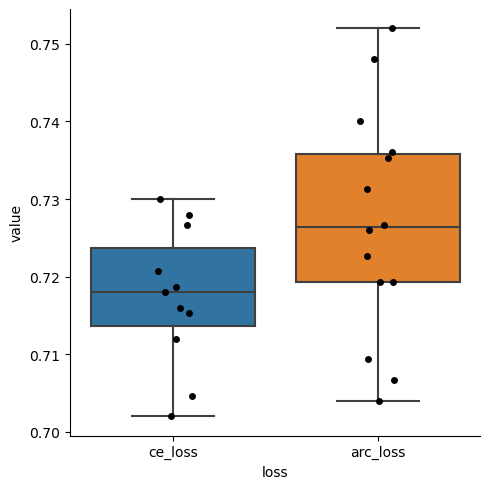

In [158]:
val_acc = pd.read_csv('./models/val_acc.csv', header=None)\
.rename(columns={0: 'value', 1: 'loss'})

thr = 0.7
g = sns.catplot(data=val_acc.query('value > @thr'), x='loss', y='value', color='k')
sns.boxplot(data=val_acc.query('value > @thr'), x='loss', y='value', ax=g.ax);

Здесь отброшены совсем "неудачные" наборы параметров (accuracy < 0.7). В целом ArcFace Loss дает качество выше. 

In [159]:
tpr_fpr = pd.read_csv('./models/tpr_fpr.csv')
tpr_fpr = tpr_fpr.pivot(index='fpr', columns='loss', values='tpr')

tpr_fpr.sort_index(axis=0, ascending=False)\
.sort_index(axis=1, ascending=False)\
.style.background_gradient(cmap ='RdYlBu') 

TPF@FPR при обучении на ArcFace Loss также выше. </br>
Посморим на отображение эмбеддингов в двумерное пространство. 

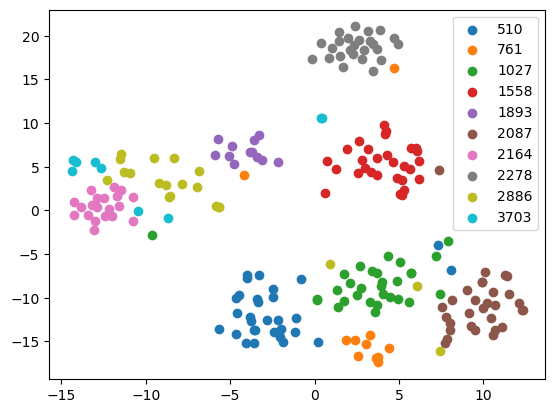

In [249]:
from sklearn import manifold

query_size = 10
u_labels = np.random.choice(np.unique(labels[val_idx]), size=query_size)
query_idx = np.where(np.isin(labels, u_labels))[0]
query_img_names = imgs[query_idx]
query_labels = labels[query_idx]
query_embeddings = compute_embeddings(model, query_img_names)

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
data_2d_tsne = tsne.fit_transform(query_embeddings.cpu())

fig, ax = plt.subplots()
for label in np.unique(query_labels):
    i = np.where(query_labels == label)
    ax.scatter(data_2d_tsne[i, 0], data_2d_tsne[i, 1], label=label)
ax.legend();

Выглядит неплохо. Классы разделяются.

### Triplet Loss

Сначала переписал код TensorFlow [отсюда](https://omoindrot.github.io/triplet-loss#triplet-mining), но обучение не пошло. Точнее код запустился, но loss не сходился к минимуму. В итоге решил взять готовую реализацию [отсюда](https://github.com/alfonmedela/triplet-loss-pytorch/blob/master/loss_functions/triplet_loss.py).

In [29]:
# Source https://github.com/alfonmedela/triplet-loss-pytorch/blob/master/loss_functions/triplet_loss.py

def pairwise_distance_torch(embeddings):
    ''' Computes the pairwise distance matrix with numerical stability.
        output[i, j] = || feature[i, :] - feature[j, :] ||_2
    Args:
        embeddings: 2-D Tensor of size [number of data, feature dimension].
    Returns:
        pairwise_distances: 2-D Tensor of size [number of data, number of data].
    '''
    # pairwise distance matrix with precise embeddings
    precise_embeddings = embeddings.to(dtype=torch.float32)

    c1 = torch.pow(precise_embeddings, 2).sum(axis=-1)
    c2 = torch.pow(precise_embeddings.transpose(0, 1), 2).sum(axis=0)
    c3 = precise_embeddings @ precise_embeddings.transpose(0, 1)

    c1 = c1.reshape((c1.shape[0], 1))
    c2 = c2.reshape((1, c2.shape[0]))
    c12 = c1 + c2
    pairwise_distances_squared = c12 - 2.0 * c3

    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = torch.max(pairwise_distances_squared, torch.tensor([0.]).to(device))
    # Get the mask where the zero distances are at.
    error_mask = pairwise_distances_squared.clone()
    error_mask[error_mask > 0.0] = 1.
    error_mask[error_mask <= 0.0] = 0.

    pairwise_distances = torch.mul(pairwise_distances_squared, error_mask)

    # Explicitly set diagonals to zero.
    mask_offdiagonals = torch.ones((pairwise_distances.shape[0], 
                                    pairwise_distances.shape[1])) - torch.diag(torch.ones(pairwise_distances.shape[0]))
    pairwise_distances = torch.mul(pairwise_distances.to(device), mask_offdiagonals.to(device))
    return pairwise_distances

def TripletSemiHardLoss(y_true, y_pred, margin=1.0):
    ''' Computes the triplet loss_functions with semi-hard negative mining. The loss_functions encourages the positive 
        distances (between a pair of embeddings with the same labels) to be smaller than the minimum negative distance
        among which are at least greater than the positive distance plus the margin constant (called semi-hard negative) 
        in the mini-batch. If no such negative exists, uses the largest negative distance instead.
        See: https://arxiv.org/abs/1503.03832.
        We expect labels `y_true` to be provided as 1-D integer `Tensor` with shape [batch_size] of multi-class integer 
        labels. And embeddings `y_pred` must be 2-D float `Tensor` of l2 normalized embedding vectors.
    Args:
        margin: Float, margin term in the loss_functions definition. Default value is 1.0.
        name: Optional name for the op.
        '''
    labels, embeddings = y_true, y_pred

    # Reshape label tensor to [batch_size, 1].
    lshape = labels.shape
    labels = torch.reshape(labels, [lshape[0], 1])

    pdist_matrix = pairwise_distance_torch(embeddings)

    # Build pairwise binary adjacency matrix.
    adjacency = torch.eq(labels, labels.transpose(0, 1))
    # Invert so we can select negatives only.
    adjacency_not = adjacency.logical_not()

    batch_size = labels.shape[0]

    # Compute the mask.
    pdist_matrix_tile = pdist_matrix.repeat(batch_size, 1)
    adjacency_not_tile = adjacency_not.repeat(batch_size, 1)

    transpose_reshape = pdist_matrix.transpose(0, 1).reshape(-1, 1)
    greater = pdist_matrix_tile > transpose_reshape

    mask = adjacency_not_tile & greater

    # final mask
    mask_step = mask.to(dtype=torch.float32)
    mask_step = mask_step.sum(axis=1)
    mask_step = mask_step > 0.0
    mask_final = mask_step.reshape(batch_size, batch_size)
    mask_final = mask_final.transpose(0, 1)

    adjacency_not = adjacency_not.to(dtype=torch.float32)
    mask = mask.to(dtype=torch.float32)

    # negatives_outside: smallest D_an where D_an > D_ap.
    axis_maximums = torch.max(pdist_matrix_tile, dim=1, keepdim=True)
    masked_minimums = torch.min(torch.mul(pdist_matrix_tile - axis_maximums[0], mask), dim=1, keepdim=True)[0] + axis_maximums[0]
    negatives_outside = masked_minimums.reshape([batch_size, batch_size])
    negatives_outside = negatives_outside.transpose(0, 1)

    # negatives_inside: largest D_an.
    axis_minimums = torch.min(pdist_matrix, dim=1, keepdim=True)
    masked_maximums = torch.max(torch.mul(pdist_matrix - axis_minimums[0], adjacency_not), dim=1, keepdim=True)[0] + axis_minimums[0]
    negatives_inside = masked_maximums.repeat(1, batch_size)

    semi_hard_negatives = torch.where(mask_final, negatives_outside, negatives_inside)

    loss_mat = margin + pdist_matrix - semi_hard_negatives

    mask_positives = adjacency.to(dtype=torch.float32) - torch.diag(torch.ones(batch_size)).to(device)
    num_positives = mask_positives.sum()

    triplet_loss = (torch.max(torch.mul(loss_mat, mask_positives), torch.tensor([0.]).to(device))).sum() / num_positives
    triplet_loss = triplet_loss.to(dtype=embeddings.dtype)
    return triplet_loss


class TripletLoss(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.kwargs = kwargs

    def forward(self, input, target):
        return TripletSemiHardLoss(target, input, **self.kwargs)

Accuracy считал сначала с помощью KNeighborsClassifier. Метрика была в разы меньше по сравнению с оценками на 2-х моделях ранее, хотя IR примерно тот же. Решил эмбеддинги отдать в один полносвязный слой, который обучается отдельно от основной сети, но с тем же набором параметров. В итоге метрика на валидация +- такая же, как из KNeighborsClassifier. В общем смысла в этом, видимо, нет. Но теперь уже оставляю как есть.

In [29]:
class Scorer(torch.nn.Module):
    def __init__(self):
        super(Scorer, self).__init__()
        in_features = ResNet50().net.fc.in_features
        out_features = n_classes
        self.fc = torch.nn.Linear(in_features, out_features, bias=False)
    
    def forward(self, x, return_features=False):
        return self.fc(x)
        

def _get_embeddings(model, loader):
    embeddings = []
    targets = []
    model.eval()

    for inputs, labels in loader:
        inputs = inputs.to(device)
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs, return_features=True)
        
        embeddings.append(outputs)
        targets.append(labels)
    return torch.vstack(embeddings), torch.hstack(targets)
    

class Embeddings(Dataset):
    def __init__(self, embeddings, labels):
        super().__init__()
        self.embeddings = embeddings.detach().cpu()
        self.labels = labels
        self.len_ = len(self.embeddings)

    def __len__(self):
        return self.len_
        
    def __getitem__(self, index):
        return self.embeddings[index], self.labels[index]

In [30]:
def train_triplet(model, criterion, epochs=50, lr=1e-3, weight_decay=5e-4, step_size=5, step_gamma=0.5, 
          embeddings=True, verbose=1): 
    
    state_dict = os.path.join(working_dir, 'checkpoint.pt')
    early_stopping = EarlyStopping(path=state_dict)
    
    scorer = Scorer().to(device)
    ce_loss = torch.nn.CrossEntropyLoss()
    
    optimizer = {
        'clf': torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay),
        'scorer': torch.optim.Adam(scorer.parameters(), lr=lr, weight_decay=weight_decay),
    }
    scheduler = {
        'clf': lr_scheduler.StepLR(optimizer['clf'], step_size=step_size, gamma=step_gamma),
        'scorer': lr_scheduler.StepLR(optimizer['scorer'], step_size=step_size, gamma=step_gamma)
    }
    
    history = []
    print('Epoch\tLr\t Loss_t\t Loss_v\t Acc_t\t Acc_v')
          
    for epoch in range(epochs):
        train_loss, _ = fit_epoch(model, train_loader, criterion, optimizer['clf'], embeddings)
        val_loss, _ = eval_epoch(model, val_loader, criterion, embeddings)
        scheduler['clf'].step()

        tr_ds = Embeddings(*_get_embeddings(model, train_loader))
        ts_ds = Embeddings(*_get_embeddings(model, val_loader))

        tr_loader = DataLoader(
            tr_ds, 
            batch_size=batch_size, 
            num_workers=num_workers, 
            shuffle=False,
        )
        ts_loader = DataLoader(
            ts_ds,
            batch_size=batch_size, 
            num_workers=num_workers, 
            shuffle=False,
        )   

        _, train_acc = fit_epoch(scorer, tr_loader, ce_loss, optimizer['scorer'])
        _, val_acc = eval_epoch(scorer, ts_loader, ce_loss)
        scheduler['scorer'].step()
        
        history.append((train_loss, train_acc, val_loss, val_acc))
        if not epoch % verbose:
            lr = scheduler['clf'].optimizer.param_groups[0]['lr']
            print('%d/%d\t%.1e\t %.3f\t %.3f\t %.4f\t %.4f' \
                  % (epoch+1, epochs, lr, train_loss, val_loss, train_acc, val_acc))

        early_stopping(model, val_loss)
        if early_stopping.state:
            break
    model.load_state_dict(torch.load(state_dict))
    
    return history

Подбирать гиперпараметры по оценке другого классификатора, параметры которого от итерации к итерации меняются, кажется не очень хорошей идеей. Поэтому эмбеддинги из валидационного датасета отправляю в LinearSVC и на 3-х фолдах считаю Balanced Accuracy. 

In [36]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import make_scorer, balanced_accuracy_score
from imblearn.over_sampling import RandomOverSampler

def _compute_metric(model, data_loader):
    model.eval()
    X = []
    y = []
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        X.append(outputs.cpu().detach())
        y.append(labels)
    
    X = torch.cat(X)
    y = torch.cat(y)
    rus = RandomOverSampler(random_state=0)
    X_res, y_res = rus.fit_resample(X, y)
    
    clf = LinearSVC(dual='auto', multi_class='ovr', random_state=0)
    skf = StratifiedKFold(n_splits=3, shuffle=False)
    scorer = make_scorer(balanced_accuracy_score)
    
    score = cross_val_score(clf, X_res, y_res, scoring=scorer, cv=skf)
    return score.mean()

In [143]:
from hyperopt import hp, fmin, tpe, STATUS_OK
from hyperopt.early_stop import no_progress_loss

def hyperopt_objective(params):
    print(params)
    m = params.pop('margin')
    criterion = TripletLoss(margin=m)
    model = ResNet50().to(device)
    history = train_triplet(model, criterion, **params, verbose=5)
    try:
        metric = _compute_metric(model, val_loader)
    except ValueError:
        metric = 0.
    print('Balanced Acc: %.4f' % metric)
    return {'loss': -metric, 
            'status': STATUS_OK}

space = {
    'lr': hp.uniform('lr', 1e-5, 1e-4),
    'weight_decay': hp.uniform('weight_decay', 1e-5, 1e-4),
    'step_size': hp.randint('step_size', 3, 10),
    'step_gamma': hp.uniform('step_gamma', 0.1, 0.8),
    'margin': hp.uniform('margin', 0.1, 3.),
}

best = fmin(hyperopt_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=80,
    early_stop_fn=no_progress_loss(15))

best_params = best.copy()

{'lr': 1.0052399535433739e-05, 'margin': 1.7811031872902299, 'step_gamma': 0.2820957109436392, 'step_size': 6, 'weight_decay': 5.5667938846691715e-05}
Epoch	Lr	 Loss_t	 Loss_v	 Acc_t	 Acc_v                                                                                          
1/50	1.0e-05	 1.765	 1.767	 0.0023	 0.0013                                                                                      
6/50	2.8e-06	 1.751	 1.758	 0.0251	 0.0200                                                                                      
11/50	2.8e-06	 1.748	 1.754	 0.0423	 0.0287                                                                                     
Balanced Acc: 0.0887                                                                                                            
{'lr': 7.007904524262309e-05, 'margin': 0.15035592057408512, 'step_gamma': 0.4253178134214597, 'step_size': 5, 'weight_decay': 7.93887368785786e-05}
Epoch	Lr	 Loss_t	 Loss_v	 Acc_t	 Acc_v                 

In [144]:
best_params

{'lr': 9.617639111234632e-05,
 'margin': 0.9357479221969323,
 'step_gamma': 0.7455445961958027,
 'step_size': 9,
 'weight_decay': 7.549548585506665e-05}

In [32]:
m = best_params.pop('margin')
criterion = TripletLoss(margin=m)
model = ResNet50().to(device)
history = train_triplet(model, criterion, **best_params)

Epoch	Lr	 Loss_t	 Loss_v	 Acc_t	 Acc_v
1/50	9.6e-05	 0.915	 0.910	 0.0199	 0.0413
2/50	9.6e-05	 0.911	 0.917	 0.0352	 0.0580
3/50	9.6e-05	 0.911	 0.905	 0.0902	 0.1080
4/50	9.6e-05	 0.903	 0.914	 0.1359	 0.1213
5/50	9.6e-05	 0.900	 0.899	 0.1861	 0.1807
6/50	9.6e-05	 0.894	 0.891	 0.2210	 0.1947
7/50	9.6e-05	 0.892	 0.896	 0.2355	 0.1973
8/50	9.6e-05	 0.885	 0.872	 0.2491	 0.2173
9/50	7.2e-05	 0.881	 0.873	 0.3177	 0.2500
10/50	7.2e-05	 0.872	 0.867	 0.3315	 0.2647
11/50	7.2e-05	 0.869	 0.848	 0.3404	 0.2800
12/50	7.2e-05	 0.863	 0.867	 0.3570	 0.2907
13/50	7.2e-05	 0.857	 0.843	 0.3780	 0.2860
14/50	7.2e-05	 0.856	 0.856	 0.3932	 0.2980
15/50	7.2e-05	 0.843	 0.856	 0.3122	 0.2507
16/50	7.2e-05	 0.840	 0.865	 0.3831	 0.2827
17/50	7.2e-05	 0.835	 0.819	 0.3738	 0.2927
18/50	5.3e-05	 0.833	 0.843	 0.4012	 0.2913
19/50	5.3e-05	 0.823	 0.837	 0.4262	 0.3213
20/50	5.3e-05	 0.804	 0.831	 0.4292	 0.3247
21/50	5.3e-05	 0.805	 0.842	 0.4426	 0.3293
22/50	5.3e-05	 0.799	 0.808	 0.4398	 0.3193
23

Balanced Accuracy на тестовой выборке:

In [37]:
_compute_metric(model, test_loader)

0.26266666666666666

In [38]:
query_embeddings = compute_embeddings(model, query_img_names)
distractors_embeddings = compute_embeddings(model, distractors_img_names)

cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names.tolist(),
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names.tolist(),
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, distractors_embeddings)

In [39]:
tpr_fpr = tpr_fpr_test(cosine_query_pos, cosine_query_neg, cosine_query_distractors)
print(tpr_fpr.round(2))

    fpr   thr   tpr
0  0.50  0.07  0.99
1  0.20  0.20  0.86
2  0.10  0.30  0.70
3  0.05  0.38  0.59


In [40]:
path = './models/tpr_fpr.csv'
pd.concat([
    pd.read_csv(path),
    tpr_fpr.assign(loss=['triplet_loss']*tpr_fpr.shape[0])
]).to_csv(path, index=False)

In [41]:
save_model('best_clf_triplet.pt')

### Triplet Loss + ArcFace Loss

Здесь для обучения нужны и эмбеддинги, и логиты, поэтому немного поправил архитектуру и функции для обучения.

In [39]:
class ResNet50v2(torch.nn.Module):
    def __init__(self, n_classes=500, normalize_features=True):
        super(ResNet50v2, self).__init__()
        self.net = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        for param in self.net.parameters():
            param.requires_grad = False
        for param in self.net.layer4.parameters():
            param.requires_grad = True
        self.net.fc = torch.nn.Linear(self.net.fc.in_features, n_classes, bias=False)
        self.normalize_features = normalize_features
    
    def forward(self, x, return_features=False):
        if self.normalize_features:
            seq = torch.nn.Sequential(*list(self.net.children())[:-1])
            x = seq(x)
            embeddings = F.normalize(x.reshape(-1, self.net.fc.in_features), dim=1)
            x = self.net.fc(embeddings)
            logits = F.normalize(x, dim=1)
            return embeddings, logits if return_features else logits
        else:
            x = self.net(x)
            return x

In [33]:
class TripletArcFaceLoss(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.arc_loss = ArcLoss().to(device)

    def forward(self, embeddings, logits, labels):
        triplet_loss = TripletSemiHardLoss(labels, embeddings)
        arc_loss = self.arc_loss(logits, labels)
        return triplet_loss + arc_loss

In [34]:
def fit_epoch(model, train_loader, criterion, optimizer, embeddings=False):
    running_loss = 0.
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        embeddings, logits = model(inputs, return_features=True)
        loss = criterion(embeddings, logits, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(logits, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc


def eval_epoch(model, val_loader, criterion, embeddings=False):
    model.eval()
    running_loss = 0.
    running_corrects = 0
    processed_data = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            embeddings, logits = model(inputs, return_features=True)
            loss = criterion(embeddings, logits, labels)
        
        preds = torch.argmax(logits, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    
    val_loss = running_loss / processed_data
    val_acc = running_corrects.cpu().numpy() / processed_data
    return val_loss, val_acc

В этот раз при подборе гипепараметров буду максимизировать IR. Наборы query и distractors беру из оставшейся части данных для обучения. 

In [35]:
qd_idx = np.where(idx == 0)[0]
qd_idx = qd_idx[~np.isin(qd_idx, train_idx)]

val_query_idx = qd_idx[:query_size]
val_distractors_idx = qd_idx[query_size: query_size+distractors_size]

val_query_img_names = imgs[val_query_idx]
val_distractors_img_names = imgs[val_distractors_idx]

val_query_dict = defaultdict(list)
for img_name, img_class in zip(imgs[val_query_idx], labels[val_query_idx]):
    val_query_dict[img_class].append(img_name)

In [36]:
np.isin(val_query_img_names, val_distractors_img_names).sum(), \
np.isin(train_imgs, val_query_img_names).sum(), \
np.isin(train_imgs, val_distractors_img_names).sum()

(0, 0, 0)

Изображений из наборов val_query и val_distractors в тренировочном и валидационном датасетах нет.

In [41]:
from hyperopt import hp, fmin, tpe, STATUS_OK
from hyperopt.early_stop import no_progress_loss

def _compute_embeddings(model, images_list, path=sample_dir):
    n_imgs = len(images_list)
    dataset = CelebA_Dataset(images_list, [0]*n_imgs, path, mode='test')
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval
    embeddings = []
    for inputs, _ in loader:
        inputs = inputs.to(device)
        with torch.set_grad_enabled(False):
            outputs, _ = model(inputs, return_features=True)
        embeddings.append(outputs)
    embeddings = torch.concat(embeddings)
    return embeddings    

def _compute_metric(model, query_img_names, distractors_img_names, query_dict):
    query_embeddings = _compute_embeddings(model, query_img_names)
    distractors_embeddings = _compute_embeddings(model, distractors_img_names)
    
    cosine_query_pos = compute_cosine_query_pos(
        query_dict, query_img_names.tolist(), query_embeddings)
    cosine_query_neg = compute_cosine_query_neg(
        query_dict, query_img_names.tolist(), query_embeddings)
    cosine_query_distractors = compute_cosine_query_distractors(
        query_embeddings, distractors_embeddings)
    
    tpr_fpr = tpr_fpr_test(cosine_query_pos, cosine_query_neg, cosine_query_distractors)
    print(tpr_fpr.round(2))
    return tpr_fpr

def hyperopt_objective(params):
    print(params)
    triplet_margin = params.pop('triplet_margin')
    arc_radius = params.pop('arc_radius')
    arc_margin = params.pop('arc_margin')
    criterion = TripletArcFaceLoss(**{
        'triplet_margin': triplet_margin, 'arc_radius': arc_radius, 'arc_margin': arc_margin
    })
    model = ResNet50v2().to(device)
    history = train(model, criterion, epochs=80, **params, verbose=5)
    metric = _compute_metric(model, val_query_img_names, val_distractors_img_names, 
                             val_query_dict)
    return {'loss': -metric.tpr.sum(), 
            'status': STATUS_OK}

space = {
    'lr': hp.uniform('lr', 1e-5, 1e-4),
    'weight_decay': hp.uniform('weight_decay', 1e-5, 1e-4),
    'step_size': hp.randint('step_size', 3, 10),
    'step_gamma': hp.uniform('step_gamma', 0.1, 0.8),
    'triplet_margin': hp.uniform('triplet_margin', 0.1, 3.),
    'arc_radius': hp.randint('arc_radius', 10, 100),
    'arc_margin': hp.uniform('arc_margin', 0.1, 0.5),
    
}

best = fmin(hyperopt_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=80,
    early_stop_fn=no_progress_loss(15))

best_params = best.copy()

{'arc_margin': 0.41842858196334476, 'arc_radius': 88, 'lr': 4.8671475569236886e-05, 'step_gamma': 0.15313389389791468, 'step_size': 8, 'triplet_margin': 2.152498034229554, 'weight_decay': 7.416638643920833e-05}
Epoch	Lr	 Loss_t	 Loss_v	 Acc_t	 Acc_v                                                                                          
1/80	4.9e-05	 14.440	 13.379	 0.0101	 0.0180                                                                                    
6/80	4.9e-05	 6.060	 10.202	 0.7288	 0.3300                                                                                     
11/80	7.5e-06	 3.049	 9.422	 0.9171	 0.4060                                                                                     
    fpr   thr   tpr                                                                                                             
0  0.50  0.30  0.92
1  0.20  0.38  0.70
2  0.10  0.43  0.59
3  0.05  0.47  0.45
{'arc_margin': 0.23511521775025557, 'arc_radius': 21, 'lr': 7.63

In [47]:
best_params

{'arc_margin': 0.3477992818889462,
 'arc_radius': 97,
 'lr': 9.146985118744594e-05,
 'step_gamma': 0.4038706658267746,
 'step_size': 8,
 'triplet_margin': 2.742103653073859,
 'weight_decay': 6.150147507789206e-05}

In [61]:
triplet_margin = best_params.pop('triplet_margin')
arc_radius = best_params.pop('arc_radius')
arc_margin = best_params.pop('arc_margin')
criterion = TripletArcFaceLoss(**{
    'triplet_margin': triplet_margin, 'arc_radius': arc_radius, 'arc_margin': arc_margin
})
model = ResNet50v2().to(device)
history = train(model, criterion, **best_params)

Epoch	Lr	 Loss_t	 Loss_v	 Acc_t	 Acc_v
1/50	9.1e-05	 13.773	 12.842	 0.0251	 0.0533
2/50	9.1e-05	 11.692	 11.492	 0.1749	 0.1673
3/50	9.1e-05	 9.320	 10.478	 0.4221	 0.2907
4/50	9.1e-05	 6.434	 9.653	 0.6912	 0.3807
5/50	9.1e-05	 4.447	 9.307	 0.8396	 0.4200
6/50	9.1e-05	 3.299	 8.966	 0.9098	 0.4467
7/50	9.1e-05	 2.686	 8.788	 0.9388	 0.4473
8/50	3.7e-05	 2.301	 8.602	 0.9579	 0.4827
9/50	3.7e-05	 1.876	 8.377	 0.9740	 0.4840
10/50	3.7e-05	 1.735	 8.240	 0.9798	 0.5087
11/50	3.7e-05	 1.693	 8.263	 0.9804	 0.5053
12/50	3.7e-05	 1.607	 8.200	 0.9837	 0.5100
13/50	3.7e-05	 1.555	 8.116	 0.9866	 0.5133
14/50	3.7e-05	 1.514	 8.084	 0.9875	 0.5213
15/50	3.7e-05	 1.468	 8.063	 0.9889	 0.5207
16/50	1.5e-05	 1.434	 7.991	 0.9901	 0.5333
17/50	1.5e-05	 1.337	 7.903	 0.9918	 0.5353
18/50	1.5e-05	 1.313	 7.902	 0.9928	 0.5320
19/50	1.5e-05	 1.289	 7.853	 0.9930	 0.5340
20/50	1.5e-05	 1.292	 7.842	 0.9932	 0.5373
21/50	1.5e-05	 1.260	 7.854	 0.9944	 0.5340
22/50	1.5e-05	 1.246	 7.847	 0.9939	 0.54

Accuracy на тестовой выборке:

In [62]:
_, test_acc = eval_epoch(model, test_loader, criterion)
test_acc.item()

0.5613333333333334

IR на наборах query и distractors:

In [63]:
tpr_fpr = _compute_metric(model, query_img_names, distractors_img_names, query_dict)

    fpr   thr   tpr
0  0.50  0.23  0.97
1  0.20  0.31  0.84
2  0.10  0.35  0.69
3  0.05  0.39  0.55


In [64]:
path = './models/tpr_fpr.csv'
pd.concat([
    pd.read_csv(path),
    tpr_fpr.assign(loss=['triplet_arc_loss']*tpr_fpr.shape[0])
]).to_csv(path, index=False)

In [66]:
save_model('best_clf_triplet_arc.pt')

### TPR@FPR vs Loss

In [76]:
tpr_fpr = pd.read_csv('./models/tpr_fpr.csv')
tpr_fpr = tpr_fpr.pivot(index='fpr', columns='loss', values='tpr')
tpr_fpr.sort_index(axis=0, ascending=False)\
.style.background_gradient(cmap ='RdYlBu') 

## Модель выравнивания

In [55]:
landmarks_align = '/mnt/hd0/data/CelebA/Anno/list_landmarks_align_celeba.txt'

In [56]:
landmarks = open(landmarks_align, 'r')
landmarks = [f.strip().split()[1:] for f in landmarks.readlines()[2:]]
landmarks = np.array(landmarks, dtype='int32')
train_imgs = imgs[train_idx]
train_landmarks = landmarks[train_idx]
train_landmarks = np.stack([
    train_landmarks[:,list(range(0,10,2))],
    train_landmarks[:,list(range(1,10,2))]
], axis=2)
train_imgs.shape, train_landmarks.shape

((15000,), (15000, 5, 2))

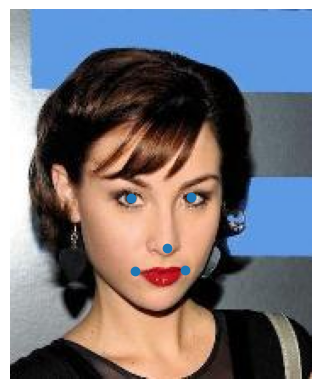

In [57]:
img_name = '148274.jpg'
image = Image.open(os.path.join(sample_dir, img_name))
image_id = np.where(train_imgs == img_name)[0][0]
plt.imshow(image)
plt.scatter(train_landmarks[image_id,:,0], train_landmarks[image_id,:,1])
plt.axis('off');

### Предобработка изображений

Код для обработки изображений взял [отсюда](https://towardsdatascience.com/face-landmarks-detection-with-pytorch-4b4852f5e9c4).</br> Архитектуру сети не менял. На выходе 10 классов, поскольку имеется 5 ключевых точек, в остальном без изменений.</br> Loss - среднеквадратичная ошибка. Метрика - R$^2$.

In [58]:
# Source https://towardsdatascience.com/face-landmarks-detection-with-pytorch-4b4852f5e9c4
import cv2
import imutils
import torchvision.transforms.functional as TF
from math import cos, sin, radians, atan, degrees


class Transforms():
    def __init__(self):
        pass

    def rotate(self, image, landmarks, angle, random_angle=True):
        if random_angle:
            angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))],
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return image, new_landmarks

    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = v2.ColorJitter(brightness=0.3, 
                                      contrast=0.3,
                                      saturation=0.3,
                                      hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks):
        top, left = 53, 33
        height, width = 112, 112
        image = TF.crop(image, top, left, height, width)
        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)

        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks


class CelebA_LandmarksDataset(Dataset):
    def __init__(self, files, landmarks, path, transform=None):
        vfun = np.vectorize(lambda x: os.path.join(path, x))
        self.files = vfun(np.array(files))
        self.landmarks = landmarks
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        image = cv2.imread(self.files[index])
        landmarks = self.landmarks[index,:,:]
        if self.transform:
            image, landmarks = self.transform(image, landmarks)
        landmarks = landmarks - 0.5
        return image, landmarks

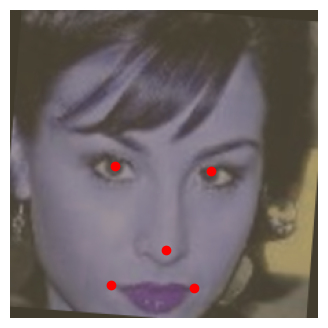

In [62]:
dataset = CelebA_LandmarksDataset(
    train_imgs, train_landmarks, sample_dir, transform=Transforms())
image, landmarks = dataset[image_id]
mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
image = image.permute(1,2,0).numpy() * std + mean
landmarks = (landmarks + 0.5) * 224
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.scatter(landmarks[:,0], landmarks[:,1], c='r')
plt.axis('off');

In [63]:
len(dataset)

15000

In [64]:
from torch.utils.data import random_split

batch_size = 128
num_workers = 4

train_dataset, \
val_dataset, \
test_dataset = random_split(dataset, [0.8, 0.1, 0.1])

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=True
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    num_workers=num_workers, 
    shuffle=False
)
len(train_loader), len(val_loader), len(test_loader)

(94, 12, 12)

### Функции для обучения

In [65]:
if not os.path.exists('torcheval'):
    !git clone https://github.com/pytorch/torcheval signin
    !mv ./signin/torcheval ./ && rm -rf ./signin

In [66]:
import torcheval
from torcheval.metrics.functional import r2_score

def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.
    running_r2 = 0.

    for images, landmarks in train_loader:
        images = images.to(device)
        landmarks = landmarks.view(landmarks.size(0),-1).to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, landmarks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_r2 += r2_score(outputs, landmarks)
        
    train_loss = running_loss / len(train_loader)
    train_r2 = running_r2 / len(train_loader)
    return train_loss, train_r2

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.
    running_r2 = 0.

    for images, landmarks in val_loader:
        images = images.to(device)
        landmarks = landmarks.view(landmarks.size(0),-1).to(device)

        with torch.set_grad_enabled(False):
            outputs = model(images)
            loss = criterion(outputs, landmarks)
        running_loss += loss.item()
        running_r2 += r2_score(outputs, landmarks)
    
    val_loss = running_loss / len(val_loader)
    val_r2 = running_r2 / len(val_loader)
    return val_loss, val_r2

In [67]:
def train(model, criterion, epochs=50, lr=1e-3, weight_decay=5e-4, step_size=5, step_gamma=0.5, 
          verbose=1): 
    
    state_dict = os.path.join(working_dir, 'checkpoint.pt')
    early_stopping = EarlyStopping(path=state_dict)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=step_gamma)
    
    history = []
    print('Epoch\tLr\t Loss_t\t Loss_v\t R2_t\tR2_v')
          
    for epoch in range(epochs):
        train_loss, train_r2 = fit_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_r2 = eval_epoch(model, val_loader, criterion)
        scheduler.step()
        history.append((train_loss, val_loss))
        if not epoch % verbose:
            lr = scheduler.optimizer.param_groups[0]['lr']
            print('%d/%d\t%.1e\t %.3f\t %.3f\t %.2f\t%.2f' \
                  % (epoch+1, epochs, lr, train_loss, val_loss, train_r2, val_r2))

        early_stopping(model, val_loss)
        if early_stopping.state:
            break
    model.load_state_dict(torch.load(state_dict))
    
    return history

In [35]:
criterion = torch.nn.MSELoss(reduction='sum')
model = ResNet50(n_classes=10, normalize_features=False).to(device)
hystory = train(model, criterion, lr=1e-4)

Epoch	Lr	 Loss_t	 Loss_v	 R2_t	R2_v
1/50	1.0e-04	 8.063	 2.934	 -12.44	-3.65
2/50	1.0e-04	 1.656	 0.951	 -1.26	-0.17
3/50	1.0e-04	 0.776	 0.631	 0.09	0.24
4/50	1.0e-04	 0.529	 0.461	 0.40	0.46
5/50	5.0e-05	 0.425	 0.365	 0.53	0.60
6/50	5.0e-05	 0.359	 0.335	 0.61	0.61
7/50	5.0e-05	 0.337	 0.314	 0.63	0.65
8/50	5.0e-05	 0.317	 0.297	 0.65	0.65
9/50	5.0e-05	 0.297	 0.277	 0.67	0.69
10/50	2.5e-05	 0.278	 0.266	 0.69	0.70
11/50	2.5e-05	 0.267	 0.254	 0.71	0.71
12/50	2.5e-05	 0.258	 0.252	 0.72	0.71
13/50	2.5e-05	 0.251	 0.235	 0.72	0.73
14/50	2.5e-05	 0.245	 0.236	 0.73	0.73
15/50	1.3e-05	 0.241	 0.229	 0.73	0.74
16/50	1.3e-05	 0.232	 0.222	 0.74	0.75
17/50	1.3e-05	 0.229	 0.221	 0.75	0.75
18/50	1.3e-05	 0.226	 0.212	 0.75	0.76
19/50	1.3e-05	 0.221	 0.218	 0.75	0.75
20/50	6.3e-06	 0.220	 0.214	 0.76	0.76
21/50	6.3e-06	 0.216	 0.209	 0.76	0.76
22/50	6.3e-06	 0.215	 0.212	 0.76	0.75
23/50	6.3e-06	 0.213	 0.211	 0.76	0.76
24/50	6.3e-06	 0.213	 0.204	 0.76	0.76
25/50	3.1e-06	 0.211	 0.210	 0.7

R$^2$ на тестовой выборке:

In [36]:
_, test_r2 = eval_epoch(model, test_loader, criterion)
test_r2.item()

0.7566895484924316

На мой взгляд неплохо.

In [38]:
save_model('regr.pt')

### Визуализация результатов

In [69]:
model = ResNet50(n_classes=10, normalize_features=False).to(device)
model.load_state_dict(torch.load('./models/regr.pt'))

<All keys matched successfully>

In [70]:
model.eval()
with torch.no_grad():
    images, landmarks = next(iter(test_loader))
    images = images.to(device)
    landmarks = (landmarks + 0.5) * 224
    preds = (model(images).cpu() + 0.5) * 224
    preds = preds.view(landmarks.shape)

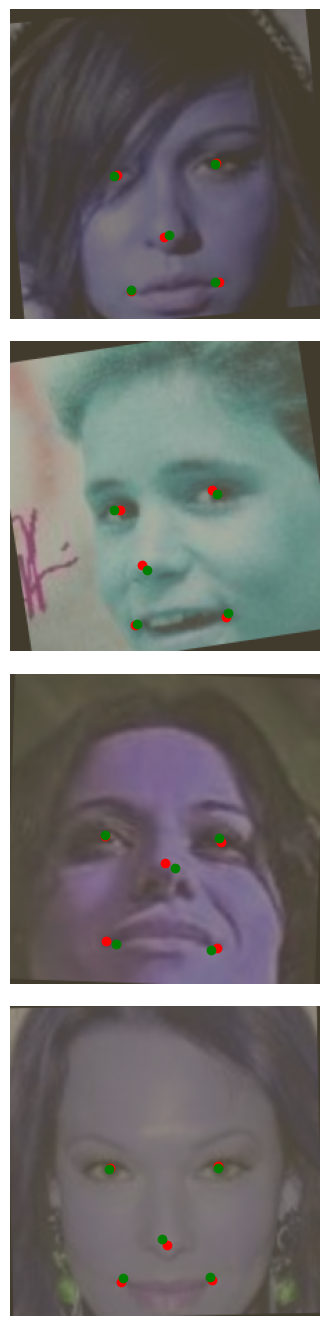

In [71]:
plt.figure(figsize=(4, 35))

for img_num in range(4):
    plt.subplot(8, 1, img_num+1)
    plt.subplots_adjust(hspace=-0.1)
    image = images[img_num].cpu().permute(1,2,0).numpy() * std + mean
    plt.imshow(image)
    plt.axis('off')
    plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c='r')
    plt.scatter(preds[img_num,:,0], preds[img_num,:,1], c='g')

Выглядит неплохо.

### Выравнивание

Поворачиваю изображения по глазам. По остальным точкам ничего не делал.

In [72]:
def rotate_back(image, landmarks):
    image = image.cpu().permute(1,2,0).numpy()
    landmarks = landmarks.cpu().numpy()
    x = landmarks[1,0] - landmarks[0,0]
    y = landmarks[1,1] - landmarks[0,1]
    angle = degrees(atan(y/x))
    return Transforms().rotate(image, landmarks, angle, random_angle=False)

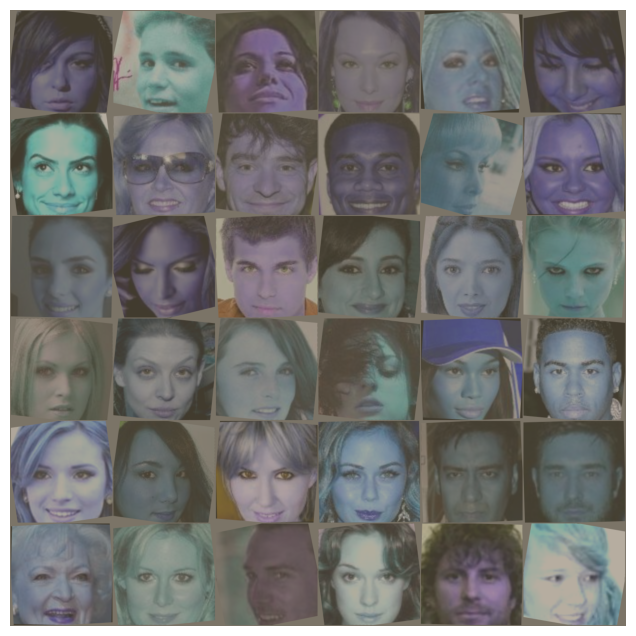

In [73]:
images_align = [rotate_back(images[img_idx], landmarks[img_idx,:,:])[0] \
                for img_idx in range(len(images))]
images_align = torch.tensor(np.stack(images_align)).permute(0,3,1,2)
grid_img = make_grid(images_align[:36], nrow=6).permute(1,2,0) * std + mean
fig, ax = plt.subplots(figsize=(8,8))
plt.axis('off')
plt.imshow(grid_img);

## Модель детекции

In [74]:
img_celeba = '/mnt/hd0/data/CelebA/Img/img_celeba'

In [75]:
if not os.path.exists(img_celeba):
    !7z x img_celeba.7z.001

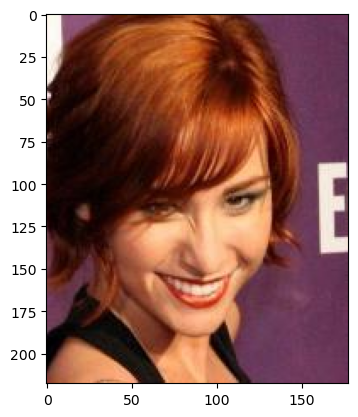

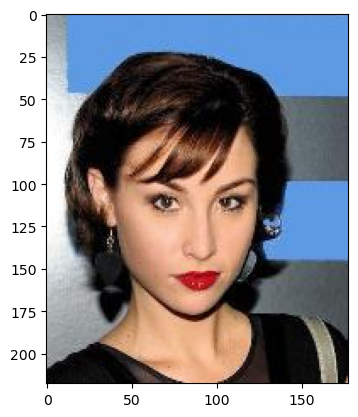

In [76]:
samples = imgs[np.where(labels == 353)[0]]
samples = vfun(samples)
for sample in [np.array(Image.open(sample)) for sample in samples[-3:]]:
    plt.imshow(sample)
    plt.show()

Беру готовую реализацию [отсюда](https://github.com/timesler/facenet-pytorch/blob/master/examples/face_tracking.ipynb).

In [77]:
if not os.path.exists('facenet_pytorch'):
    !git clone https://github.com/timesler/facenet-pytorch.git facenet_pytorch

In [78]:
from facenet_pytorch import MTCNN

In [79]:
def extract_face(img_name, path):
    mtcnn = MTCNN(selection_method='largest')
    image = np.array(Image.open(os.path.join(path, img_name)))
    frame = mtcnn(image)
    return frame

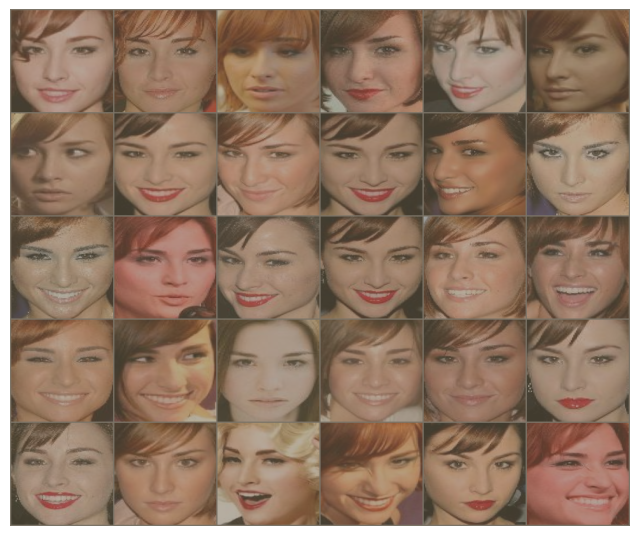

In [80]:
frames_celeba = [extract_face(sample, img_celeba) for sample in samples]
frames_celeba = torch.tensor(np.stack(frames_celeba))
grid_img = make_grid(frames_celeba, nrow=6).permute(1,2,0) * std + mean
fig, ax = plt.subplots(figsize=(8,8))
plt.axis('off')
plt.imshow(grid_img);

Похоже работает.

## Пайплайн распознавания лиц

Датасет для загрузки изображений, детекции, выравнивания и распознавания лиц:

In [31]:
class FaceEmbeddings(Dataset):
    ''' 
    Image detection, alignment and recognition
        Params:
            files: list of images names
            labels: list of labels
            path: path to directory where files are
        Return:
            embeddings corresponding to files and their labels
        Note:
            will be implemented a model trained on ArcFace 
    '''
    def __init__(self, files, labels, path):
        super().__init__()
        vfun = np.vectorize(lambda x: os.path.join(path, x))
        self.files = vfun(np.array(files))
        self.labels = np.array(labels)
        self.len_ = len(files)
        self.mtcnn = MTCNN(selection_method='largest')
        self.model_dir = './models'
        self.regr = ResNet50(n_classes=10, normalize_features=False)
        self.regr.load_state_dict(
            torch.load(os.path.join(self.model_dir, 'regr.pt')))
        self.regr.eval()
        self.transform = Transforms()
        self.clf = ResNet50()
        self.clf.load_state_dict(
            torch.load(os.path.join(self.model_dir, 'best_clf_arc.pt')))
        self.clf.eval()

    def __len__(self):
        return self.len_

    def extract_face(self, file):
        image = Image.open(file)
        frame = self.mtcnn(np.array(image))
        return frame

    def align_face(self, image):
        with torch.no_grad():
            landmarks = (self.regr(image.unsqueeze(0)) + 0.5) * 224
        landmarks = landmarks.view(5,2)
        x = landmarks[1,0] - landmarks[0,0]
        y = landmarks[1,1] - landmarks[0,1]
        angle = degrees(atan(y/x))
        image_align, _ = self.transform.rotate(
            image.permute(1,2,0), landmarks, angle, random_angle=False)
        return image_align

    def face_rec(self, image):
        image = torch.tensor(image).permute(2,0,1).unsqueeze(0)
        with torch.no_grad():
            embeddings = self.clf(image, return_features=True)
        return embeddings
        
    def __getitem__(self, index):
        x = self.files[index]
        x = self.extract_face(x)
        
        if isinstance(x, type(None)): 
            # if MTCNN failed
            self.files = np.delete(self.files, index)
            self.labels = np.delete(self.labels, index)
            return self.__getitem__(index)
        
        x = self.face_rec(self.align_face(x))
        if len(self.labels):
            y = self.labels[index]
            return x, y
        return x

Функции для расчета схожести эмбеддингов одного изображения с набором эмбеддингов, для которых известны метки классов:

In [32]:
def _compute_cosine(query_embeddings, wanted_embeddings):
    ''' compute cosine similarities between each of query_embeddings and 
        wanted_embeddings
    '''
    cos = torch.nn.CosineSimilarity()
    cossim = [cos(image_embeddinds, wanted_embeddings).item() \
              for image_embeddinds, _ in query_embeddings]
    return cossim

def compute_similarity(wanted, query_images, query_labels, fun=_compute_cosine):
    '''
    compute similarities between pairs of wanted and items from query
    params:
        wanted: name of single image for recognition
        query_images: list of images names for search
        query_labels: list of labels corresponding to query_images
    output:
        cossim: similarities between embeddings of wanted person and 
                different people from query list
        labels: labels of people corresponding to cossim
    '''    
    wanted_embeddings = FaceEmbeddings([wanted], [], img_celeba).__getitem__(0)
    
    query_dataset = FaceEmbeddings(query_images, query_labels, img_celeba)
    query_embeddings = [(X, y) for X, y in query_dataset]

    cossim = fun(query_embeddings, wanted_embeddings)
    labels = [image_class for _, image_class in query_embeddings]

    return cossim, labels

Выбираю классы из набора query, по которым имеется хотя бы 4 изображения.

In [33]:
query_images = imgs[query_idx]
query_labels = labels[query_idx]

unique = np.unique(np.array(query_labels), return_counts=True)

query_set = [(img_name, img_class) for img_name, img_class in zip(query_images, query_labels) \
             if img_class in list(unique[0][unique[1] > 3])]

np.sum(unique[1] > 3), len(query_set)

(33, 139)

Итого 33 человека, в общей сложности 139 изображений. Функция в следующей ячейке извлекает одно изображение из полученного набора, рассчитывает схожесть и выводит топ 5 файлов с сответствующими метками классов из числа оставшихся в наборе картинок. Первое изображение - для распознавания, второе - топ 1 в списке схожести. 

In [34]:
def recognize(wanted_class=None):
    '''
    pull out a single image of wanted class from query_set and then is looking for 
    that particular person in the rest of the data
        Args:
            wanted_class: might be determined otherwise it will be taken randomly from query_set
        Return:
            nothing
        Note:
            query_set will be taken from the global namespace
            the outcome includes top 5 suspects and an image of the first one
    '''
    query_images = []
    query_labels = []
    
    for img_name, img_class in query_set:
        query_images.append(img_name)
        query_labels.append(img_class)

    if not wanted_class:
        wanted_class = random.sample(query_labels, 1)[0]
    else:
        assert wanted_class in query_labels, "There is no wanted person in the query dataset"
    
    wanted_idx = query_labels.index(wanted_class)
    wanted = query_images[wanted_idx]
    plt.imshow(np.array(Image.open(os.path.join(img_celeba, wanted))))
    plt.axis('off')
    plt.title(wanted_class)
    plt.show()
    
    query_images = np.array(query_images)
    query_labels = np.array(query_labels)
    
    query_labels = query_labels[query_images != wanted]
    query_images = query_images[query_images != wanted]

    cossim, labels = compute_similarity(wanted, query_images, query_labels)
    
    cossim_df = pd.DataFrame({'cossim': cossim, 'label': labels})\
    .set_index('label').join(
        pd.DataFrame({'name': query_images, 'label': query_labels}).set_index('label'),
        on='label')
    
    df_max = cossim_df.reset_index().groupby('label').max()
    df_max.sort_values('cossim', ascending=False, inplace=True)
    print(df_max.head())

    out_img = Image.open(os.path.join(img_celeba, list(df_max.name)[0]))
    plt.imshow(np.array(out_img))
    plt.axis('off')
    plt.title("The Top of the Search List:\n" + str(df_max.reset_index().label[0]))

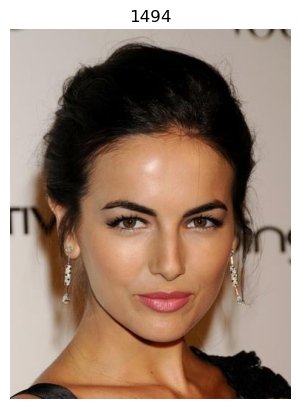

         cossim        name
label                      
1494   0.588067  175633.jpg
4453   0.546194  173327.jpg
376    0.510691  180683.jpg
1120   0.504304  180584.jpg
4049   0.496189  177667.jpg


In [35]:
recognize(1494)

         cossim        name
label                      
2884   0.551947  180405.jpg
3236   0.545344  180339.jpg
1615   0.508018  180497.jpg
4706   0.498944  181536.jpg
1164   0.493104  169613.jpg


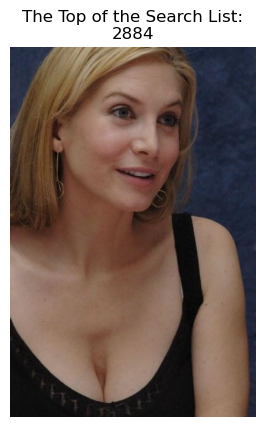

In [703]:
recognize(2884)

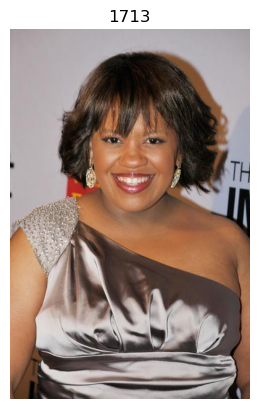

         cossim        name
label                      
4453   0.548811  173327.jpg
4049   0.457896  177667.jpg
1713   0.425444  181641.jpg
1582   0.415175  174981.jpg
1615   0.410234  180497.jpg


In [704]:
recognize()

Ну что тут сказать, модель ошибается. Но в топ 5 искомый класс есть.

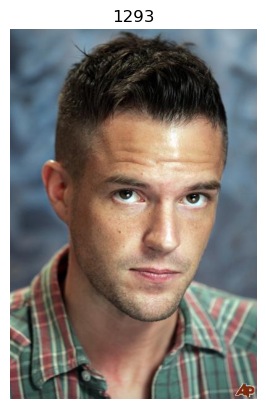

         cossim        name
label                      
4346   0.427324  182041.jpg
1293   0.412067  179826.jpg
4917   0.314768  180698.jpg
4706   0.308128  181536.jpg
2884   0.293914  180405.jpg


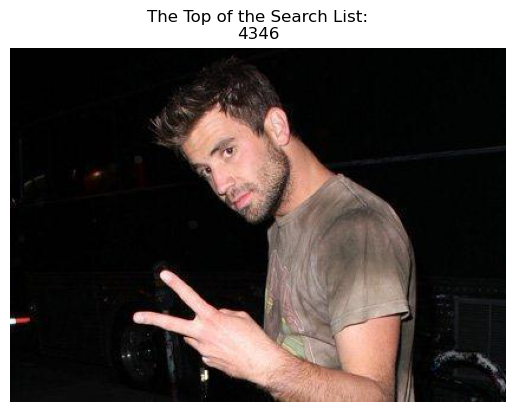

In [710]:
recognize()

Вообще похожи. И косинус мало отличается.

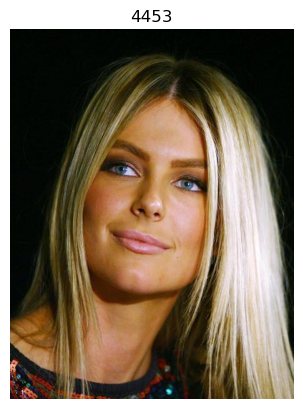

         cossim        name
label                      
1120   0.588336  180584.jpg
916    0.566276  172539.jpg
2884   0.548677  180405.jpg
1807   0.483195  176388.jpg
376    0.474594  180683.jpg


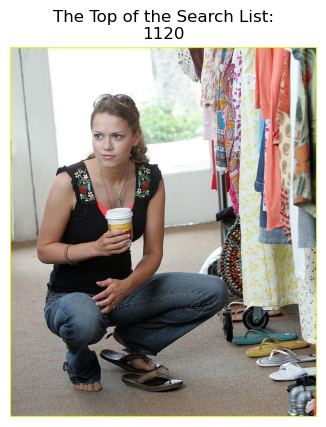

In [711]:
recognize()

Ну тут вообще мимо.

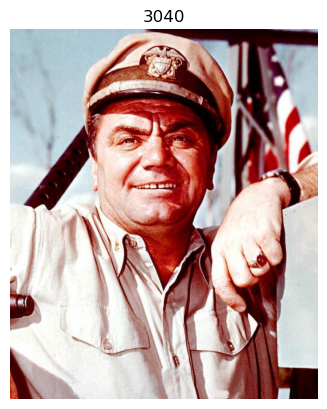

         cossim        name
label                      
3040   0.466132  176148.jpg
4917   0.442266  180698.jpg
1444   0.356441  180955.jpg
1063   0.340506  177859.jpg
1164   0.338735  169613.jpg


In [723]:
recognize()